# 실전 프로젝트 (실습)

## 실습 개요

실전 프로젝트 (실습) <br>

1) 실습 목적 <br>
 * 이번 실습에서는 실전 프로젝트(이론) 에서 배운 내용을 복습하고 구현 해보는 과정을 거쳐봅니다.<br>

2) 수강 목표
  * 실험의 필수적인 단계, 디버깅과 재현성 확보 개념을 이해하고 준비할 수 있습니다.
  * 다양한 모델 앙상블 및 성능 향상 전략을 적용하는 방법을 습득합니다.

### 실습 목차

* **1. 실습 데이터 준비**
  * 데이터 불러오기
  * 디버깅 및 재현성 확보 과정
* **2. 다양한 모델 앙상블 과정**
  * 데이터 측면
  * 모델 측면
  * 랜덤성 측면

###  데이터셋 개요 </b>

* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)


### 환경 설정

- 패키지 설치 및 임포트

In [1]:
!uv add scikit-learn numpy lightgbm pandas tqdm

Resolved 189 packages in 6ms
Audited 88 packages in 9ms


In [2]:
# 계산
import numpy as np

# 전처리
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GroupKFold,
    TimeSeriesSplit
)

# 출력 및 시각화
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# 모델링
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor

# 데이터셋 로드 및 정제
import os
import random
import joblib
import pandas as pd

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

/Users/tylersong/Desktop/workspace/learn/python/offline/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 실습 데이터 준비

```
💡 목차 개요 : 실전 프로젝트 실습을 위한 데이터를 준비합니다.
```
- **1-1 데이터 불러오기**
- **1-2 디버깅 및 재현성 확보 과정**

### 1-1 데이터 불러오기


#### 📝 설명 : (1-1)
* 데이터 분할을 진행하기에 앞서 학습에 사용 될 데이터를 불러옵니다.
* 데이터의 구성을 확인하고, 학습에 알맞는 전처리를 진행합니다.


#### 👨‍💻 코드 : (1-1)


> 이번 실습에서는 금융 도메인의 주가 데이터셋(OHLCV)을 이용합니다.


In [3]:
# 데이터셋 파일 경로 설정 (노트북 기준 상대 경로)
DATA_DIR = "data"

In [4]:
# OHLCV 데이터셋 불러오기
OHLCV_file = f"{DATA_DIR}/OHLCV.parquet"
OHLCV_data = pd.read_parquet(OHLCV_file)

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = f"{DATA_DIR}/Company.parquet"
company_data = pd.read_parquet(company_file)

In [5]:
# OHLCV은 종목별 주가와 관련된 정보를 나타내는 데이터셋입니다.
display(OHLCV_data.head(10))

# 상장법인정보 데이터셋입니다.
display(company_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,321000.000000,321000.000000,313500.000000,314000.000000,139496,-0.011024,051910
2020-01-02,38996.097656,38996.097656,37926.585938,38091.125000,190202,-0.021142,000100
2020-01-02,153187.125000,154879.796875,148955.437500,152340.781250,734725,-0.005525,068270
2020-01-02,110659.898438,111675.125000,108121.828125,109137.054688,229273,-0.009217,028260
2020-01-02,658760.312500,668649.312500,647349.937500,651914.062500,71172,-0.010393,207940
2020-01-02,26950.000000,26950.000000,26700.000000,26700.000000,489901,-0.011111,030200
2020-01-02,237000.000000,237500.000000,231500.000000,232000.000000,186494,-0.016949,006400
2020-01-02,36450.000000,36650.000000,35900.000000,35950.000000,1028130,-0.025745,086790
2020-01-02,74400.000000,74800.000000,73000.000000,73100.000000,273967,-0.018792,032830
2020-01-02,44100.000000,44300.000000,42300.000000,42500.000000,1355029,-0.040632,000270


,company,code,industry,products,listing_date,closing_month,region
0,삼성전자,005930,반도체 제조업,"메모리반도체, 시스템LSI",1975-06-11,12월,경기
1,SK하이닉스,000660,반도체 제조업,"DRAM, NAND Flash",1996-12-26,12월,경기
2,NAVER,035420,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
3,카카오,035720,소프트웨어 개발업,"메신저, 포털 서비스",2017-07-10,12월,제주
4,현대자동차,005380,자동차 제조업,"자동차, 차량부품",1974-06-28,12월,서울
5,기아,000270,자동차 제조업,"자동차, 차량부품",1973-07-21,12월,서울
6,LG화학,051910,기초화학물질 제조업,"석유화학, 첨단소재",2001-04-25,12월,서울
7,삼성SDI,006400,일차전지 및 축전지 제조업,"이차전지, 전자재료",1979-03-09,12월,경기
8,삼성바이오로직스,207940,의약품 제조업,바이오의약품 위탁생산,2016-11-10,12월,인천
9,셀트리온,068270,의약품 제조업,바이오시밀러 의약품,2008-09-23,12월,인천


- 이번 실습을 시작하기 전에 우리는 크게 두 가지 성향의 파생 변수를 만들고 시작할거에요.
- 첫 번째는 금융 도메인 지식에 기반해서 파생 변수를 만들고 시작할게요!
- 자칫 어려울수도 있으나, 주가 관련한 금융 도메인에서는 이런 파생 변수가 존재하는걸 인지만하시고 넘어가시면 됩니다.

In [6]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] + OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.ewm(span=12, adjust=False).mean())
OHLCV_data['LongEMA'] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.ewm(span=26, adjust=False).mean())
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 두 번째는 상장법인정보를 기반으로 만들어볼거에요!
- 업종(industry), 주요 제품(products), 상장일(listing_date) 등을 결합해서 새로운 파생 변수를 만들어보도록 하겠습니다.

In [7]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

- 학습을 위해서 범주형 변수를 인코딩 하는 작업을 하겠습니다.
- Label Encoding, Frequency Encdoing, Target Encoding

In [8]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
industry_label_encoder = LabelEncoder()
OHLCV_data["LEncodedIndustry"] = industry_label_encoder.fit_transform(OHLCV_data["industry"])

code_label_encoder = LabelEncoder()
OHLCV_data["LEncodedCode"] = code_label_encoder.fit_transform(OHLCV_data["code"])

products_label_encoder = LabelEncoder()
OHLCV_data["LEncodedProducts"] = products_label_encoder.fit_transform(OHLCV_data["products"])

region_label_encoder = LabelEncoder()
OHLCV_data["LEncodedRegion"] = region_label_encoder.fit_transform(OHLCV_data["region"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

- 마지막으로 결측치와 학습에 불필요한 컬럼들은 모두 제거하겠습니다.

In [9]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [10]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2020-06-25 00:00:00 ~ 2023-07-28 00:00:00'

In [11]:
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-07-01"].reset_index(drop=True)
test_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-07-01"].reset_index(drop=True)

display(f"학습세트 : {len(train_data)} 개")
display(f"평가세트 : {len(test_data)} 개")

'학습세트 : 23913 개'

'평가세트 : 671 개'

In [12]:
# Target컬럼을 학습 데이터셋에서 제거하도록 하겠습니다.
target_col = "Target"
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")
print("\n")

# 시계열 데이터이기 때문에 인덱스를 기준으로 train/test로 분할합니다. (랜덤으로 분할하지 않도록 주의하세요!)
X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_test = test_data[input_cols]
Y_test = test_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Test Target : {Y_test.shape}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'Date', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'UpperBollingerBand', 'LowerBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedCode', 'LEncodedProducts', 'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (23913, 43)'

'Train Target : (23913,)'

'Test Input : (671, 43)'

'Test Target : (671,)'

### 1-2 디버깅 및 재현성 확보 과정

#### 📝 설명 : (1-2)
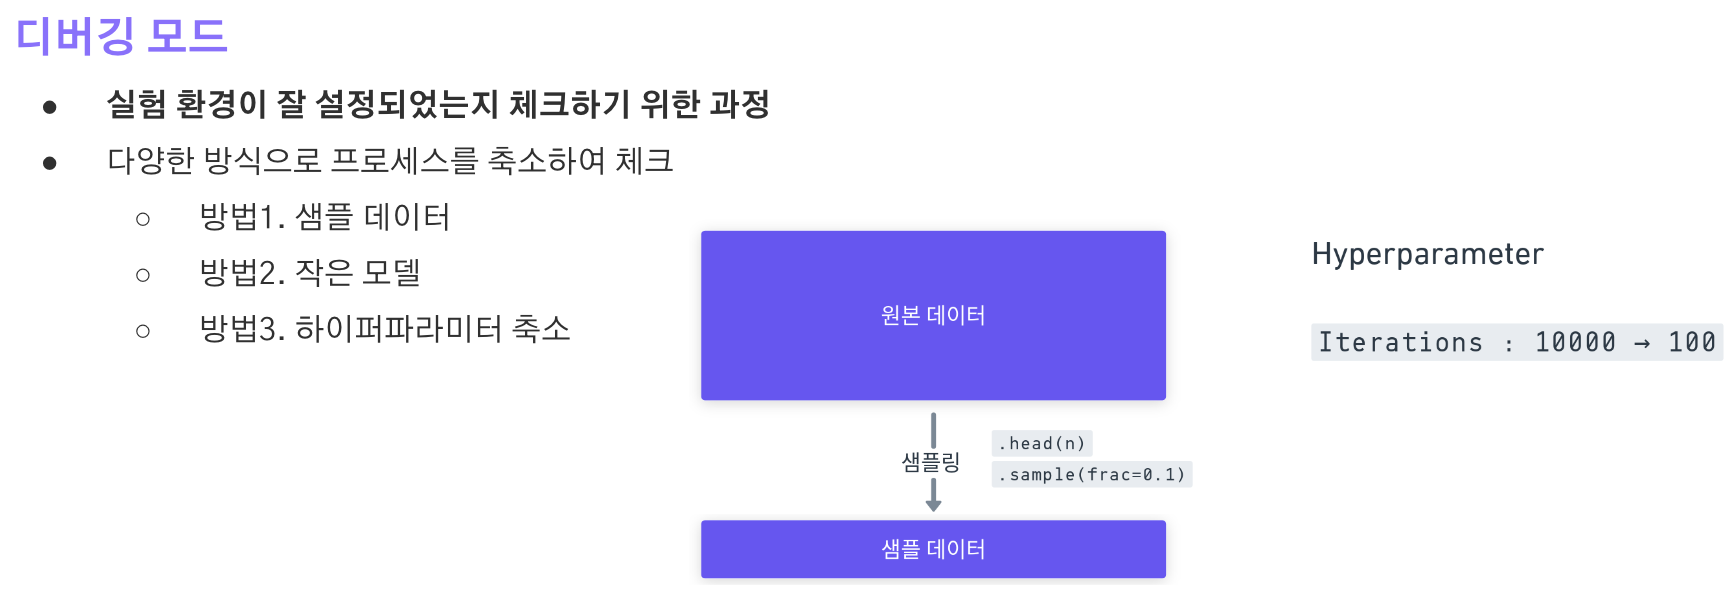
- 디버깅 모드는 방법마다 구현 위치가 달라질 수 있습니다. 가장 대표적으로는 샘플링을 통해서 일부만 추출해서 문제가 없는지 확인하는 방법을 사용합니다.


#### 👨‍💻 코드 : (1-2)

In [13]:
DEBUG_MODE = True

In [14]:
# .sample을 통해서 데이터의 1% 만큼만 샘플링을 합니다.
if DEBUG_MODE:
    display(f"샘플링 전 데이터의 비율 : {X_train.shape}")
    X_train = X_train.sample(frac=0.01) # 원래는 _X_train 대신 X_train 으로 선언해야 해당 쉘 이후 코드가 문제 없이 돌아갑니다. 다만, 실습 자료에서는 이후 원할한 실습을 위해서 샘플링 전 원본 데이터로 진행하겠습니다.
    Y_train = Y_train.loc[X_train.index] # X_train과 동일한 인덱스로 Y_train도 샘플링합니다.
    X_train = X_train.reset_index(drop=True) # KFold의 위치 기반 인덱스와 맞추기 위해 인덱스를 리셋합니다.
    Y_train = Y_train.reset_index(drop=True)
    display(f"샘플링 후 데이터의 비율 : {X_train.shape}")

'샘플링 전 데이터의 비율 : (23913, 43)'

'샘플링 후 데이터의 비율 : (239, 43)'

- 만일, 정상적으로 1%의 데이터만 쓰면 학습 시간이 대폭적으로 감소해서 코드의 이상을 알기가 더 쉽습니다.
- 비록 현재 데이터의 경우 70만 row의 양이 많지 않은 데이터셋이지만, 캐글의 일부 대회나 현업 데이터는 몇천만 로그, 몇억 단위도 심심치 않게 있습니다.
- 이런 경우 원본 데이터로 오류가 있는지 먼저 확인하는건 시간이 너무 오래걸리고 리스크가 있습니다.
- 그렇기에, 디버깅 모드를 통해 코드의 이상 유무를 확인하는 과정을 꼭 거치기 바랍니다.


In [15]:
# 재현성 확보

# 확보 전 : 돌릴때마다 달라지는 것을 확인할 수 있음
for i in range(5):
    display(f"시도 {i}번째")
    display(np.random.choice([1,2,3,4,5]))
    display(np.random.choice([1,2,3,4,5]))
    display(np.random.choice([1,2,3,4,5]))

'시도 0번째'

np.int64(4)

np.int64(4)

np.int64(2)

'시도 1번째'

np.int64(2)

np.int64(4)

np.int64(3)

'시도 2번째'

np.int64(2)

np.int64(2)

np.int64(5)

'시도 3번째'

np.int64(2)

np.int64(5)

np.int64(3)

'시도 4번째'

np.int64(3)

np.int64(2)

np.int64(3)

In [16]:
# 확보 후 : [4,5,3] 계속 반복되는 것을 확인할 수 있음
for i in range(5):
    display(f"시도 {i}번째")
    np.random.seed(42)
    display(np.random.choice([1,2,3,4,5]))
    display(np.random.choice([1,2,3,4,5]))
    display(np.random.choice([1,2,3,4,5]))

'시도 0번째'

np.int64(4)

np.int64(5)

np.int64(3)

'시도 1번째'

np.int64(4)

np.int64(5)

np.int64(3)

'시도 2번째'

np.int64(4)

np.int64(5)

np.int64(3)

'시도 3번째'

np.int64(4)

np.int64(5)

np.int64(3)

'시도 4번째'

np.int64(4)

np.int64(5)

np.int64(3)

- np.random.seed(42)를 적용한 경우와 그렇지 않은 경우를 비교하면, 값이 계속 바뀌는 것을 볼 수 있습니다.
- 따라서 seed 고정을 통해 코드를 실행할 때마다 동일한 난수 패턴을 얻어 재현성을 보장할 수 있습니다.


In [17]:

# 일반적으로 대표적으로 고정하는 부분은 아래와 같습니다.
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# 만약 파이토치를 사용하는 경우
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

In [18]:
# 그 외에도 SEED들어가는 모슨 요소에 대해 시드 고정을 해야합니다.
# 대표적으로는 train, test split할때 (kfold 등)도 있고 LightGBM과 같은 모델의 하이퍼 파라미터에서도 고정해야할 필요가 있습니다.
_, _ = train_test_split(OHLCV_data, test_size=0.2, random_state=seed)

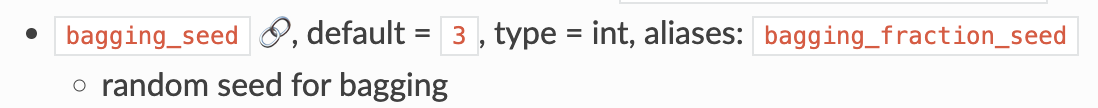

- LightGBM의 경우에도 공식문서를 참고하시면 많은 seed 관련 하이퍼파라미터가 존재합니다.
- 디폴트 값이 존재하기는 하지만, 여러 상황에서의 고정을 위해 해당 하이퍼파라미터들도 고정하는 것을 추천합니다!

## 2. 다양한 모델 앙상블 과정

```
💡 목차 개요 : 다양한 앙상블을 적용해봅니다.
```
- **2-1 데이터 측면**
- **2-2 모델 측면**
- **2-3 랜덤성 측면**

### 2-1 데이터 측면


#### 📝 설명 : (2-1)

- 데이터 측면에서의 앙상블은 다양하게 진행될 수 있습니다.
- Kfold를 이용해서 학습 데이터를 다르게 한 부분이 가장 대표적이고, 캐글에서는 전처리 및 변수를 정제하여 앙상블을 적용하기도 합니다.
- 여기선 KFold 방법에 대해 알아보고, 그 다음 전처리 및 변수를 정제하여 앙상블을 진행해보겠습니다.

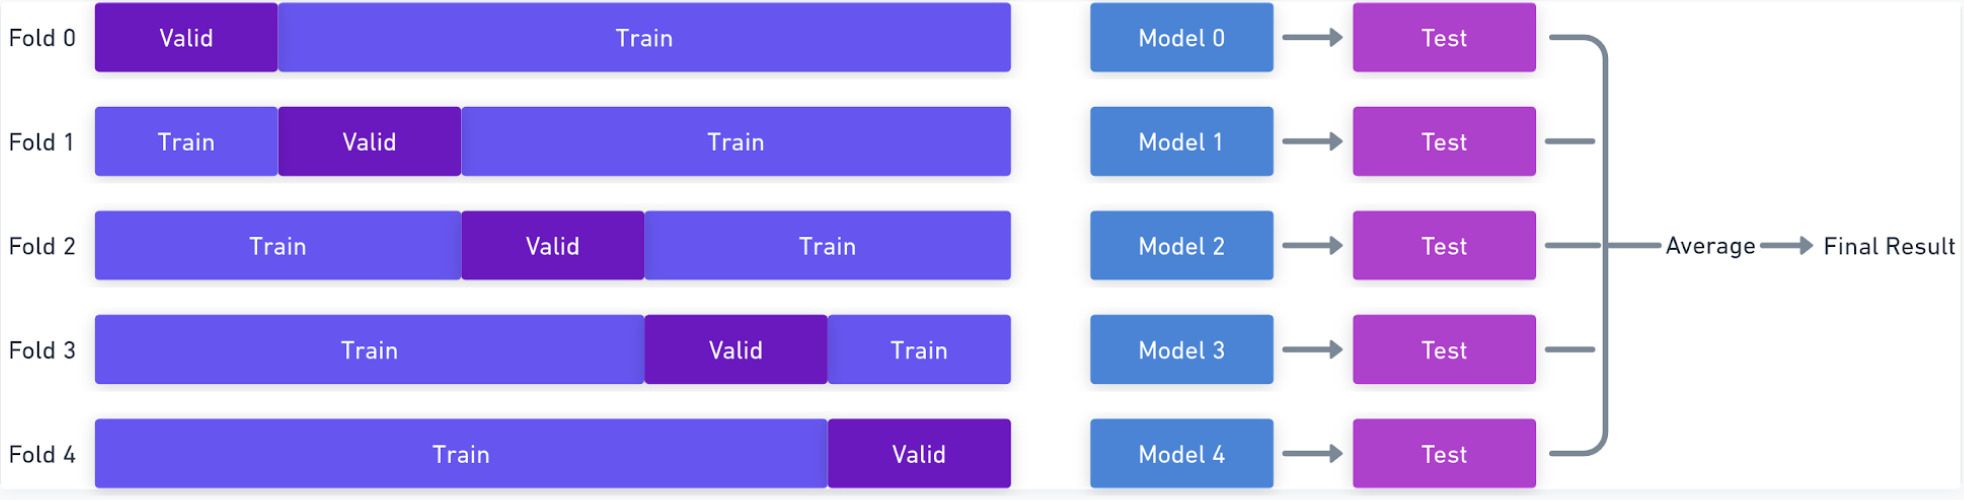

#### 👨‍💻 코드 : (2-1)
- 먼저, 각 앙상블 방법이 얼마나 의미가 있는지 확인하기 전에 베이스라인의 성능을 측정하겠습니다.
- 베이스라인의 경우 Holdout 분할 방법을 이용해 분리하도록 하겠습니다.
- 단, 주가 데이터의 경우 시계열의 특성을 따르니 검증기간을 한달로 분할하도록 하겠습니다.


In [19]:
# 베이스라인 용 데이터 셋 생성
holdout_X_train = X_train.copy()
holdout_Y_train = Y_train.copy()

In [20]:
# 날짜를 기준으로 최근 한 달의 데이터를 검증 데이터로 설정
holdout_X_train['Date'] = pd.to_datetime(holdout_X_train['Date'])
validation_start_date = holdout_X_train['Date'].max() - pd.Timedelta(days=30)
validation_indices = holdout_X_train[holdout_X_train['Date'] >= validation_start_date].index

# 위에서 얻은 인덱스를 사용하여 holdout_X_train 및 holdout_Y_train을 훈련 및 검증 데이터로 분리
holdout_X_valid = holdout_X_train.loc[validation_indices]
# 검증기간의 인덱스는 제외시켜줍니다.
holdout_X_train.drop(validation_indices, inplace=True)

holdout_Y_valid = holdout_Y_train[validation_indices]
# 검증기간의 인덱스는 제외시켜줍니다.
holdout_Y_train.drop(validation_indices, inplace=True)

display(f"수정된 학습 데이터의 기간: {holdout_X_train['Date'].min()} {holdout_X_train['Date'].max()}")
display(f"수정된 검증 데이터의 기간: {holdout_X_valid['Date'].min()} {holdout_X_valid['Date'].max()}")

'수정된 학습 데이터의 기간: 2020-06-29 00:00:00 2023-05-22 00:00:00'

'수정된 검증 데이터의 기간: 2023-06-05 00:00:00 2023-06-22 00:00:00'

In [21]:
# Gradient Boosting Machine을 선언합니다.
# 학습은 총 1,000번을 반복합니다.
gbm = lgb.LGBMRegressor(n_estimators=1000, random_state=42, subsample=0.7, subsample_freq=1, verbose=-1)

In [22]:
# 학습을 진행합니다.
# 비교를 위해 %%time을 이용해 학습시간을 측정합니다.
# 다만, date변수의 경우 바로 학습에 사용할 수 없으니 제외합니다.
features = [c for c in holdout_X_train.columns if c not in ["Date"]]

# 이전 셀에서 이미 holdout_X_train/holdout_Y_train과 holdout_X_valid/holdout_Y_valid가 분리되었으므로
# 인덱스를 초기화하여 정렬합니다.
holdout_X_train = holdout_X_train.reset_index(drop=True)
holdout_Y_train = holdout_Y_train.reset_index(drop=True)
holdout_X_valid = holdout_X_valid.reset_index(drop=True)
holdout_Y_valid = holdout_Y_valid.reset_index(drop=True)

# 길이 일치 여부 확인 (디버깅용)
assert len(holdout_X_train) == len(holdout_Y_train), f"훈련 feature와 레이블의 길이가 다릅니다: {len(holdout_X_train)} vs {len(holdout_Y_train)}"
assert len(holdout_X_valid) == len(holdout_Y_valid), f"검증 feature와 레이블의 길이가 다릅니다: {len(holdout_X_valid)} vs {len(holdout_Y_valid)}"

print(f"훈련 feature shape: {holdout_X_train[features].shape}, 레이블 shape: {holdout_Y_train.shape}")
print(f"검증 feature shape: {holdout_X_valid[features].shape}, 레이블 shape: {holdout_Y_valid.shape}")

gbm.fit(
    holdout_X_train[features],
    holdout_Y_train,
    eval_set=[
         (holdout_X_train[features], holdout_Y_train),
         (holdout_X_valid[features], holdout_Y_valid)
        ],
    eval_metric ='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10, show_stdv=True)
        ]
)

훈련 feature shape: (232, 42), 레이블 shape: (232,)
검증 feature shape: (7, 42), 레이블 shape: (7,)
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 118335	valid_0's l2: 1.40032e+10	valid_1's rmse: 42265.5	valid_1's l2: 1.78637e+09
[20]	valid_0's rmse: 93059.5	valid_0's l2: 8.66007e+09	valid_1's rmse: 19769	valid_1's l2: 3.90815e+08
Early stopping, best iteration is:
[19]	valid_0's rmse: 94640.4	valid_0's l2: 8.95681e+09	valid_1's rmse: 18478.1	valid_1's l2: 3.41439e+08


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [23]:
# Test set에 대한 rmse를 측정합니다.
predicts = gbm.predict(X_test[features])
RMSE = mean_squared_error(Y_test, predicts)**0.5
display(f"Test rmse : {RMSE}")

'Test rmse : 84392.09163128024'

- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s
  - Valid RMSE : 2966.63
  - Test RMSE : 3457.82

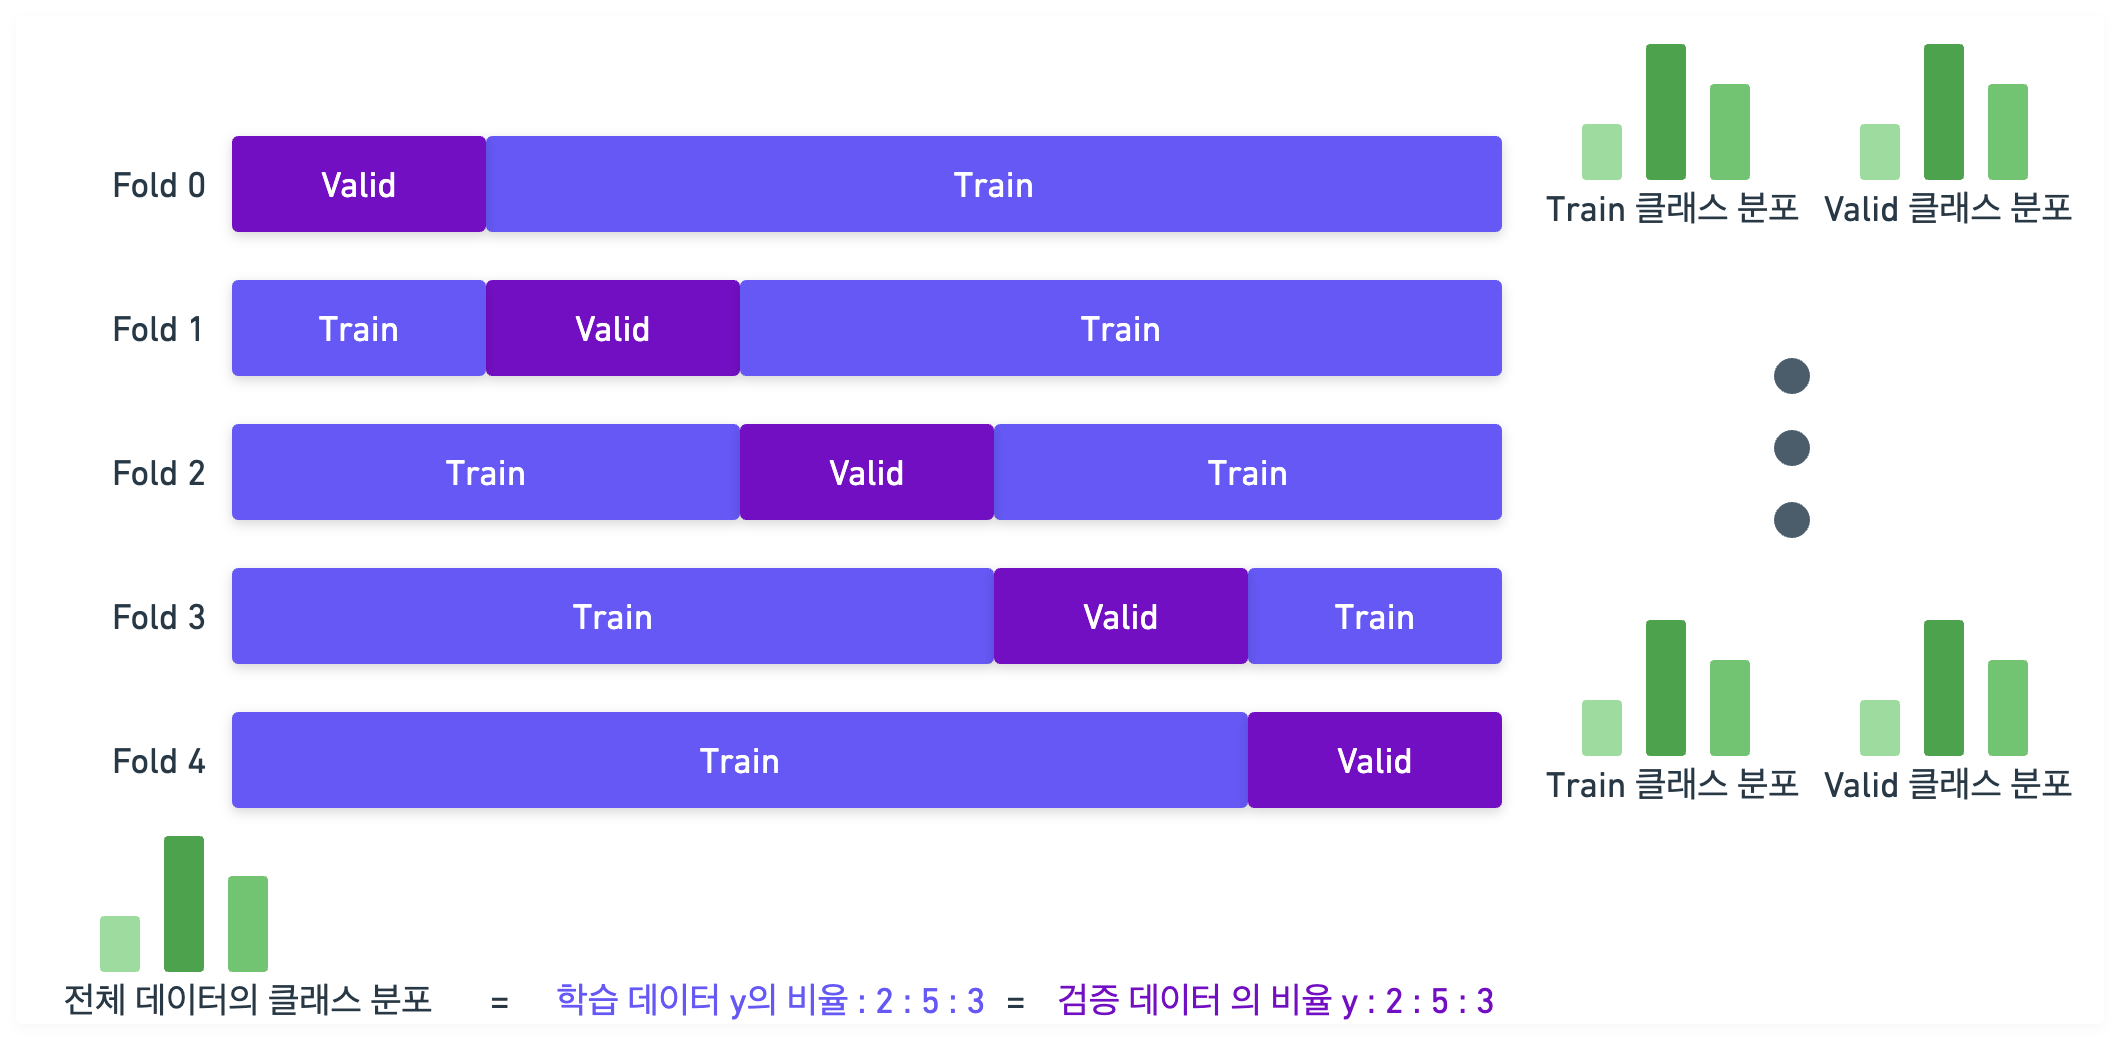

In [24]:
# 학습 데이터를 StratifiedKFoldSplit로 나눕니다.
n_folds = 5
kf = StratifiedKFold(n_splits=5)

cut_Y_train = pd.cut(Y_train,
                     1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                     labels=False)

train_folds = kf.split(X_train, cut_Y_train)
display(train_folds)

total_predicts = np.zeros(len(X_test))
total_oofs = np.zeros(len(X_train)) # array. [0, 0, ...]
for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    kfold_X_train = X_train.iloc[train_idx, :][features]
    kfold_Y_train = Y_train.iloc[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    kfold_X_valid = X_train.iloc[valid_idx, :][features]
    kfold_Y_valid = Y_train.iloc[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000, random_state=42, subsample=0.7, verbose=-1)
    gbm.fit(
        kfold_X_train,
        kfold_Y_train, # 학습 데이터를 입력합니다.
        eval_set=[
             (kfold_X_train, kfold_Y_train),
             (kfold_X_valid, kfold_Y_valid)
             ], # 평가셋을 지정합니다.
        eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[
            lgb.early_stopping(stopping_rounds=10), # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
            lgb.log_evaluation(period=10, show_stdv=True)
            ] # 매 iteration마다 학습결과를 출력합니다.
    )

    fold_predicts = gbm.predict(X_test[features])
    total_oofs[valid_idx] = gbm.predict(kfold_X_valid)
    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"Fold {fold_idx} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / n_folds

RMSE = mean_squared_error(Y_train, total_oofs)**0.5
display(f"최종 Valid rmse : {RMSE}")

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

<generator object _BaseKFold.split at 0x11e9b5030>

'--------0번째 fold의 학습을 시작합니다.--------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 116260	training's l2: 1.35163e+10	valid_1's rmse: 127297	valid_1's l2: 1.62046e+10
[20]	training's rmse: 89926.4	training's l2: 8.08676e+09	valid_1's rmse: 100031	valid_1's l2: 1.00061e+10
[30]	training's rmse: 80041.6	training's l2: 6.40665e+09	valid_1's rmse: 89549.9	valid_1's l2: 8.01919e+09
[40]	training's rmse: 72383.7	training's l2: 5.2394e+09	valid_1's rmse: 81853	valid_1's l2: 6.69991e+09
[50]	training's rmse: 65883.3	training's l2: 4.3406e+09	valid_1's rmse: 75183.9	valid_1's l2: 5.65262e+09
[60]	training's rmse: 60168.5	training's l2: 3.62025e+09	valid_1's rmse: 70058.1	valid_1's l2: 4.90813e+09
[70]	training's rmse: 55251.1	training's l2: 3.05268e+09	valid_1's rmse: 65626.9	valid_1's l2: 4.30688e+09
[80]	training's rmse: 51002.5	training's l2: 2.60125e+09	valid_1's rmse: 61686.1	valid_1's l2: 3.80518e+09
[90]	training's rmse: 47073.8	training's l2: 2.21595e+09	valid_1's rmse: 57999	valid_1's l

'Fold 0 - Test rmse : 39693.02364890527'

'--------1번째 fold의 학습을 시작합니다.--------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 124135	training's l2: 1.54094e+10	valid_1's rmse: 61320.2	valid_1's l2: 3.76017e+09
[20]	training's rmse: 95254.9	training's l2: 9.0735e+09	valid_1's rmse: 40069.1	valid_1's l2: 1.60554e+09
[30]	training's rmse: 83022.7	training's l2: 6.89277e+09	valid_1's rmse: 41116	valid_1's l2: 1.69053e+09
[40]	training's rmse: 71343.7	training's l2: 5.08992e+09	valid_1's rmse: 38935.8	valid_1's l2: 1.516e+09
[50]	training's rmse: 62972.7	training's l2: 3.96556e+09	valid_1's rmse: 37006.2	valid_1's l2: 1.36946e+09
[60]	training's rmse: 55791.3	training's l2: 3.11266e+09	valid_1's rmse: 36421.4	valid_1's l2: 1.32652e+09
[70]	training's rmse: 50169.9	training's l2: 2.51702e+09	valid_1's rmse: 35311.6	valid_1's l2: 1.24691e+09
[80]	training's rmse: 45096.5	training's l2: 2.0337e+09	valid_1's rmse: 34308	valid_1's l2: 1.17704e+09
[90]	training's rmse: 41011.7	training's l2: 1.68196e+09	valid_1's rmse: 33411.3	valid_1's l

'Fold 1 - Test rmse : 38506.28424948543'

'--------2번째 fold의 학습을 시작합니다.--------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 107061	training's l2: 1.14621e+10	valid_1's rmse: 167110	valid_1's l2: 2.79258e+10
[20]	training's rmse: 76536.1	training's l2: 5.85778e+09	valid_1's rmse: 136390	valid_1's l2: 1.86021e+10
[30]	training's rmse: 68136.7	training's l2: 4.64261e+09	valid_1's rmse: 125565	valid_1's l2: 1.57665e+10
[40]	training's rmse: 62411.6	training's l2: 3.89521e+09	valid_1's rmse: 116892	valid_1's l2: 1.36638e+10
[50]	training's rmse: 57382.6	training's l2: 3.29276e+09	valid_1's rmse: 109103	valid_1's l2: 1.19036e+10
[60]	training's rmse: 53074.4	training's l2: 2.81689e+09	valid_1's rmse: 102404	valid_1's l2: 1.04865e+10
[70]	training's rmse: 49194.9	training's l2: 2.42014e+09	valid_1's rmse: 96484.2	valid_1's l2: 9.3092e+09
[80]	training's rmse: 45654.5	training's l2: 2.08433e+09	valid_1's rmse: 91082.3	valid_1's l2: 8.29598e+09
[90]	training's rmse: 42388.4	training's l2: 1.79678e+09	valid_1's rmse: 86116.7	valid_1's 

'Fold 2 - Test rmse : 44320.130131743725'

'--------3번째 fold의 학습을 시작합니다.--------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 122957	training's l2: 1.51183e+10	valid_1's rmse: 84556.3	valid_1's l2: 7.14977e+09
[20]	training's rmse: 95402.8	training's l2: 9.1017e+09	valid_1's rmse: 61165.6	valid_1's l2: 3.74123e+09
[30]	training's rmse: 84191.6	training's l2: 7.08822e+09	valid_1's rmse: 54688.1	valid_1's l2: 2.99079e+09
[40]	training's rmse: 75835.2	training's l2: 5.75097e+09	valid_1's rmse: 49575.7	valid_1's l2: 2.45775e+09
[50]	training's rmse: 68738.2	training's l2: 4.72494e+09	valid_1's rmse: 44466.7	valid_1's l2: 1.97729e+09
[60]	training's rmse: 62388.6	training's l2: 3.89234e+09	valid_1's rmse: 39284.7	valid_1's l2: 1.54329e+09
[70]	training's rmse: 56787.7	training's l2: 3.22484e+09	valid_1's rmse: 36063.6	valid_1's l2: 1.30058e+09
[80]	training's rmse: 51449.9	training's l2: 2.64709e+09	valid_1's rmse: 33496.7	valid_1's l2: 1.12203e+09
[90]	training's rmse: 47016.5	training's l2: 2.21055e+09	valid_1's rmse: 31004.8	vali

'Fold 3 - Test rmse : 39221.02140957442'

'--------4번째 fold의 학습을 시작합니다.--------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 119682	training's l2: 1.43237e+10	valid_1's rmse: 130339	valid_1's l2: 1.69884e+10
[20]	training's rmse: 95322.4	training's l2: 9.08635e+09	valid_1's rmse: 101132	valid_1's l2: 1.02276e+10
[30]	training's rmse: 85132.5	training's l2: 7.24754e+09	valid_1's rmse: 92187.9	valid_1's l2: 8.49861e+09
[40]	training's rmse: 76988.8	training's l2: 5.92727e+09	valid_1's rmse: 86627.4	valid_1's l2: 7.50431e+09
[50]	training's rmse: 70020	training's l2: 4.9028e+09	valid_1's rmse: 82317.2	valid_1's l2: 6.77611e+09
[60]	training's rmse: 63900.9	training's l2: 4.08332e+09	valid_1's rmse: 78573.3	valid_1's l2: 6.17377e+09
[70]	training's rmse: 58504.7	training's l2: 3.4228e+09	valid_1's rmse: 76395.3	valid_1's l2: 5.83624e+09
[80]	training's rmse: 53736.4	training's l2: 2.8876e+09	valid_1's rmse: 74565.8	valid_1's l2: 5.56006e+09
[90]	training's rmse: 49479.2	training's l2: 2.44819e+09	valid_1's rmse: 72763.4	valid_1's 

'Fold 4 - Test rmse : 58177.00233269398'

'최종 Valid rmse : 40337.65493566993'

'최종 Test rmse : 29909.80735476821'

- 앙상블 전후에 따른 성능을 비교하면 아래와 같습니다.
 - Training Time : 13.7s ---> 104s
 - Valid RMSE : 3658
 - Test RMSE : 3457.82 ---> 3327

- 속도 측면에서는 학습 시간이 더 오래걸렸지만, 성능적인 측면에서 개선된 것을 확인할 수 있습니다.

- 한번 이제 다른 방법으로 데이터 측면에서의 앙상블을 해보겠습니다.
- 이때, 생각해볼 수 있는 방법은 여러가지가 있습니다.
 1. 전처리를 다양하게 해서 앙상블
 2. 피처를 다양하게 해서 앙상블

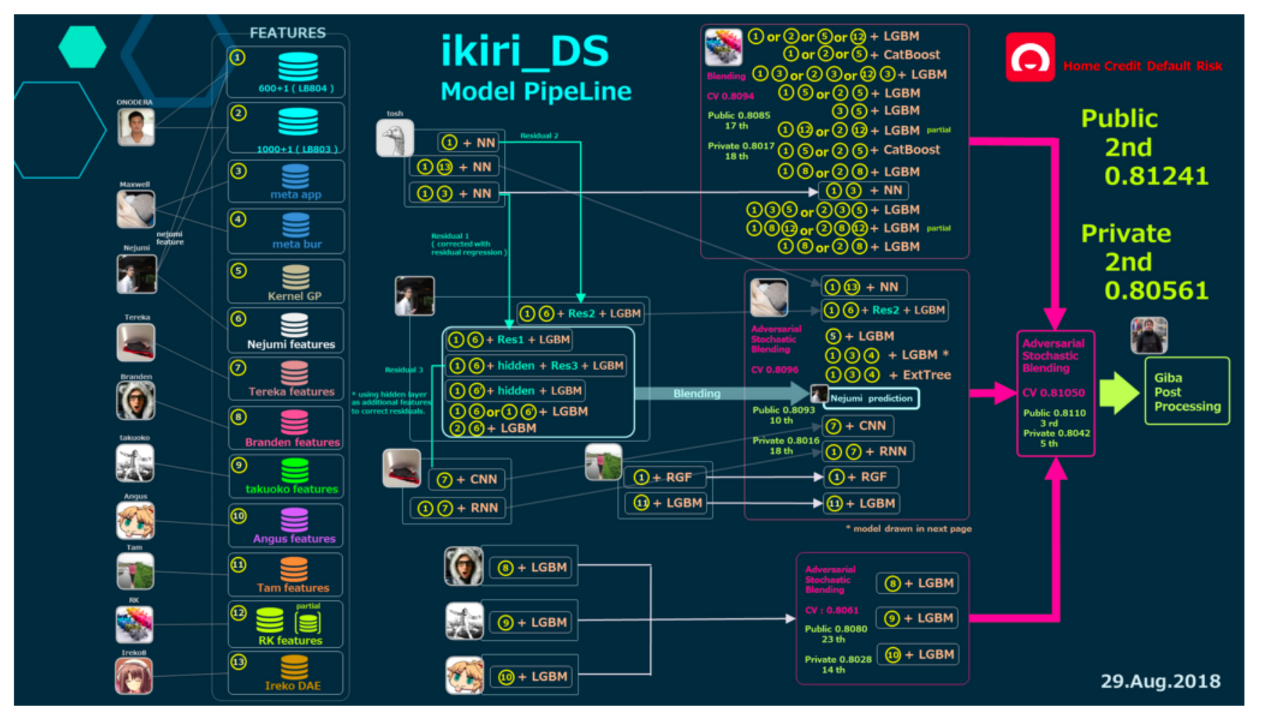

출처 : https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64722

- 두 방법 모두 자주 사용되고 유용하고 특히 팀을 꾸려서 작업하는 관점에 위와 같은 방법을 많이 사용하는 것 같습니다.
- 이번 실습에서는 그 중에서도 피처를 다양하게 해서 앙상블 하는 방법을 살펴보도록 하겠습니다.

- Feature Selection을 기반으로 하는 데이터기반의 앙상블
 - 해당 방법론의 큰 방향성은 Random Forest와 비슷한 면이 있습니다.
 - Random Forest를 생각해보면 Bagging방식으로 데이터와 피처 측면에서 일부만 선택하여 다양성을 보장합니다.
 - 마찬가지로 해당 방법도 유사합니다.
 - 다만, 피처의 선택을 다양한 피처 셀렉션 방법을 이용한다는 차이점이 존재합니다.
 - 한번 피처 셀렉션을 통해 앙상블을 진행해보도록 하겠습니다.
   - 방법1. Filter Method
   - 방법2. Feature Importance
   - 방법3. Adversarial Validation

- 편의상 변수의 선택은 빠른 작업을 위해 Random Forest를 베이스로 진행해보도록 하겠습니다.

- **[1] Filter methods**

- 변수간의 통계적 관계를 평가해 변수의 중요도를 결정하는 방법
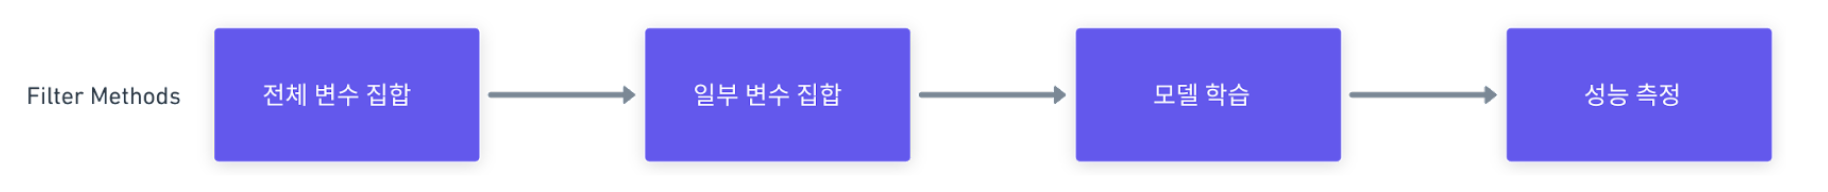
e.g. 상관성이 높은 Feature들을 찾아서 제거하는 방법 -> 상관계수 필요


In [25]:
def get_highly_correlated_features(df, threshold=0.8):
    """
    높은 상관계수를 가진 변수 쌍 중에서 한 변수를 제외한 나머지 변수들의 이름을 반환합니다.

    Parameters:
    - df: 데이터프레임
    - threshold: 상관계수 임계값

    Returns:
    - 선택된 변수명 리스트
    """

    # 상관계수 행렬 계산
    # [[1, 0.5, 0.3], [0.5, 1, ..], [...]]
    correlation_matrix = df.corr()

    # 제거 대상 변수들을 저장할 집합
    to_remove = set()

    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                to_remove.add(correlation_matrix.columns[j])

    # 제거 대상 변수를 제외하고 남은 변수들의 리스트 반환
    selected_features = [col for col in df.columns if col not in to_remove]
    return selected_features

In [26]:
features1 = get_highly_correlated_features(X_train[features], threshold=0.7)

display("Filter Method : ", features1)

'Filter Method : '

['Open',
 'Volume',
 'Change',
 'PriceDirection',
 'MACD',
 'OpenMean',
 'DateYear',
 'DateMonth',
 'DateDay',
 'ListingDateYear',
 'ListingDateMonth',
 'ListingDateDay',
 'ClosingMonthInt',
 'LEncodedIndustry',
 'LEncodedProducts',
 'LEncodedRegion',
 'FEncodedIndustry']

- **[2] Feature Importance**

In [27]:
def get_important_features(model, X_train, Y_train, threshold=0.8, upper=True):
    """
    Feature Importance를 사용하여 변수 중요도 상위 80%의 변수명을 반환합니다.

    Parameters:
    - model: 중요도를 추출한 모델
    - X_train: 학습 데이터의 독립변수
    - Y_train: 학습 데이터의 종속변수
    - threshold: 중요도 비율 (0.8은 상위 80%를 의미)

    Returns:
    - 선택된 변수명 리스트
    """

    # 변수 중요도와 변수명을 함께 저장
    feature_importances = list(zip(X_train.columns, model.feature_importances_))

    # 변수 중요도를 기준으로 정렬
    sorted_features = sorted(feature_importances, key=lambda x: x[1], reverse=True if upper else False)

    # 상위 threshold(예: 80%) 비율에 해당하는 변수의 수
    num_features_to_keep = int(threshold * len(sorted_features))

    # 상위 threshold(예: 80%)의 변수명 선택
    selected_features = [feature[0] for feature in sorted_features[:num_features_to_keep]]

    return selected_features

In [28]:
# Forward Feature Selection
forest_rf = RandomForestRegressor(
    n_estimators=50,
    criterion='squared_error',
    random_state=seed,
    n_jobs=-1
) # 지표는 squared_error로 설정합니다.

forest_rf.fit(X_train[features], Y_train)
features2 = get_important_features(forest_rf, X_train[features], Y_train, threshold=0.7)

display("Feature Importance Method : ", features2)

'Feature Importance Method : '

['High',
 'ShortEMA',
 'Open',
 'Close',
 'AveragePrice',
 'Low',
 'LowerBollingerBand',
 'UpperBollingerBand',
 'MovingAverage20d',
 'MovingAverage5d',
 'MovingAverage120d',
 'MovingAverage60d',
 'LongEMA',
 'ListingDateYear',
 'CloseMedian',
 'LEncodedRegion',
 'OpenMedian',
 'LowMedian',
 'FEncodedIndustry',
 'TEncodedIndustry',
 'PriceRange',
 'MACD',
 'DailyReturn',
 'HighMedian',
 'CloseMean',
 'LEncodedCode',
 'OpenMean',
 'DateDay',
 'DateYear']

- **[3] Adversarial Validation**

- Train data와 test data가 얼마나 유사한지 판단하는 방법
- Train data의 target 값은 1로, Test data는 0으로 지정 후 binary classification model을 만들어 모델링

> 만약 train과 test data의 경향이 비슷하다면, 위 모델의 분류 성능은 낮을 것

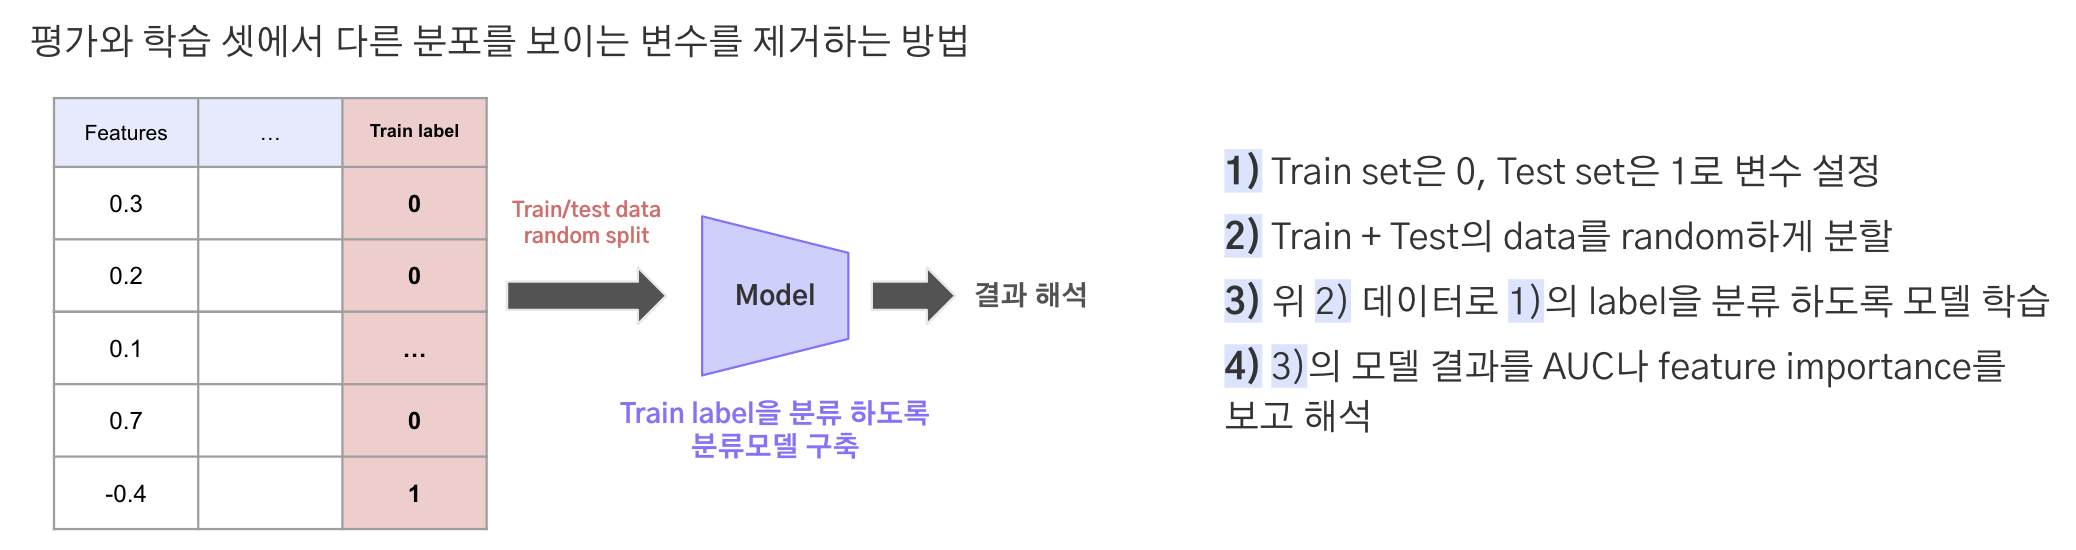

In [29]:
# train은 0, test는 1로 라벨 변수를 설정합니다.
adv_X_train = holdout_X_train.copy()
adv_X_valid = holdout_X_valid.copy()

adv_X_train['AV_label'] = 0
adv_X_valid['AV_label'] = 1

# 위 두 데이터를 합치고, 셔플합니다.
adv_data = pd.concat([adv_X_train, adv_X_valid], axis=0, ignore_index=True)
adv_data_shuffled = adv_data.sample(frac=1)
adv_X = adv_data_shuffled.drop(['AV_label'], axis=1)
adv_y = adv_data_shuffled['AV_label']

In [30]:
# Forward Feature Selection
forest_rf = RandomForestClassifier(
    n_estimators=50,
    criterion='log_loss', # log_loss
    random_state=seed,
    n_jobs=-1
)

forest_rf.fit(adv_X[features], adv_y)
features3 = get_important_features(forest_rf, adv_X[features], adv_y, threshold=0.7, upper=False)

display(f"Adversarial Method : {features3}")

"Adversarial Method : ['ClosingMonthInt', 'LEncodedRegion', 'Low', 'AveragePrice', 'ListingDateDay', 'Close', 'Open', 'MovingAverage20d', 'LEncodedProducts', 'PriceDirection', 'MovingAverage60d', 'MovingAverage5d', 'ShortEMA', 'High', 'LowMedian', 'MovingAverage120d', 'TEncodedIndustry', 'UpperBollingerBand', 'PriceRange', 'CloseMean', 'CloseMedian', 'OpenMean', 'LEncodedCode', 'DateDay', 'ListingDateMonth', 'DailyReturn', 'HighMedian', 'FEncodedIndustry', 'LowerBollingerBand']"

In [31]:
# 학습 및 예측을 위한 함수
def train_and_predict(X_train, Y_train, X_valid, Y_valid, X_test, features, random_state):
    gbm = lgb.LGBMRegressor(
        n_estimators=1000,
        random_state=random_state,
        subsample=0.7,
        subsample_freq=1,
        verbose=-1
    )

    gbm.fit(X_train[features], Y_train,
            eval_set=[(X_train[features], Y_train), (X_valid[features], Y_valid)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(period=10, show_stdv=True)]
    )

    return gbm.predict(X_test[features])

In [32]:
display("Feature1")
display(features1)

'Feature1'

['Open',
 'Volume',
 'Change',
 'PriceDirection',
 'MACD',
 'OpenMean',
 'DateYear',
 'DateMonth',
 'DateDay',
 'ListingDateYear',
 'ListingDateMonth',
 'ListingDateDay',
 'ClosingMonthInt',
 'LEncodedIndustry',
 'LEncodedProducts',
 'LEncodedRegion',
 'FEncodedIndustry']

In [33]:
display("Feature2")
display(features2)

'Feature2'

['High',
 'ShortEMA',
 'Open',
 'Close',
 'AveragePrice',
 'Low',
 'LowerBollingerBand',
 'UpperBollingerBand',
 'MovingAverage20d',
 'MovingAverage5d',
 'MovingAverage120d',
 'MovingAverage60d',
 'LongEMA',
 'ListingDateYear',
 'CloseMedian',
 'LEncodedRegion',
 'OpenMedian',
 'LowMedian',
 'FEncodedIndustry',
 'TEncodedIndustry',
 'PriceRange',
 'MACD',
 'DailyReturn',
 'HighMedian',
 'CloseMean',
 'LEncodedCode',
 'OpenMean',
 'DateDay',
 'DateYear']

In [34]:
display("Feature3")
display(features3)

'Feature3'

['ClosingMonthInt',
 'LEncodedRegion',
 'Low',
 'AveragePrice',
 'ListingDateDay',
 'Close',
 'Open',
 'MovingAverage20d',
 'LEncodedProducts',
 'PriceDirection',
 'MovingAverage60d',
 'MovingAverage5d',
 'ShortEMA',
 'High',
 'LowMedian',
 'MovingAverage120d',
 'TEncodedIndustry',
 'UpperBollingerBand',
 'PriceRange',
 'CloseMean',
 'CloseMedian',
 'OpenMean',
 'LEncodedCode',
 'DateDay',
 'ListingDateMonth',
 'DailyReturn',
 'HighMedian',
 'FEncodedIndustry',
 'LowerBollingerBand']

In [35]:
all_preds = []
for selected_features in [features1, features2, features3]:
    preds = train_and_predict(
        holdout_X_train,
        holdout_Y_train,
        holdout_X_valid,
        holdout_Y_valid,
        X_test,
        selected_features,
        42
    )
    RMSE = mean_squared_error(Y_test, preds)**0.5

    display(f"Test rmse : {RMSE}")

    all_preds.append(preds)

# 모든 예측값의 평균을 계산
ensemble_preds = np.mean(all_preds, axis=0)

# 앙상블의 RMSE를 측정
RMSE = mean_squared_error(Y_test, ensemble_preds)**0.5
display(f"Feature Selection Ensemble Test RMSE : {RMSE}")

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 118870	valid_0's l2: 1.41301e+10	valid_1's rmse: 44842.8	valid_1's l2: 2.01088e+09
[20]	valid_0's rmse: 94335.3	valid_0's l2: 8.89915e+09	valid_1's rmse: 19799.5	valid_1's l2: 3.92019e+08
[30]	valid_0's rmse: 83328.9	valid_0's l2: 6.94371e+09	valid_1's rmse: 20095.9	valid_1's l2: 4.03845e+08
Early stopping, best iteration is:
[27]	valid_0's rmse: 85970.9	valid_0's l2: 7.391e+09	valid_1's rmse: 15316.1	valid_1's l2: 2.34583e+08


'Test rmse : 76396.02658216214'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 118362	valid_0's l2: 1.40095e+10	valid_1's rmse: 44191.1	valid_1's l2: 1.95285e+09
[20]	valid_0's rmse: 93155.8	valid_0's l2: 8.67801e+09	valid_1's rmse: 20783.7	valid_1's l2: 4.3196e+08
Early stopping, best iteration is:
[19]	valid_0's rmse: 94721.6	valid_0's l2: 8.97219e+09	valid_1's rmse: 19790.2	valid_1's l2: 3.91653e+08


'Test rmse : 84438.08104742956'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 118377	valid_0's l2: 1.40131e+10	valid_1's rmse: 43771.5	valid_1's l2: 1.91595e+09
[20]	valid_0's rmse: 93026.6	valid_0's l2: 8.65395e+09	valid_1's rmse: 20256.4	valid_1's l2: 4.10322e+08
Early stopping, best iteration is:
[19]	valid_0's rmse: 94608.3	valid_0's l2: 8.95073e+09	valid_1's rmse: 19065.4	valid_1's l2: 3.63491e+08


'Test rmse : 84241.35692822645'

'Feature Selection Ensemble Test RMSE : 80864.16154558693'

In [36]:
# 모든 예측값의 평균을 계산
ensemble_preds = np.mean(all_preds[1:], axis=0)

# 앙상블의 RMSE를 측정
RMSE = mean_squared_error(Y_test, ensemble_preds)**0.5

display(f"Feature Selection Ensemble Test RMSE : {RMSE}")

'Feature Selection Ensemble Test RMSE : 84293.3171549769'

- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s
  - Valid RMSE : 2966.63
  - Test RMSE : 3457.82

- 피처 셀력선 전후에 따른 성능을 비교하면 아래와 같습니다.
 - Valid RMSE : [4166, 2839, 2801]
 - Test RMSE : [4410, 3417, 3377]  ---> 3435
 - Test RMSE : [3417, 3377]  ---> 3384


### 2-2 모델 측면


#### 📝 설명 : (2-2)

- 모델 측면에서의 앙상블도 다양한 방법이 존재합니다.
- 여러개의 모델들을 조합해서 할 수도 있고, Kfold를 이용해서 Stacking을 할수도 있습니다.
- 이번 실습에서는 Stacking을 알아보도록 하겠습니다.

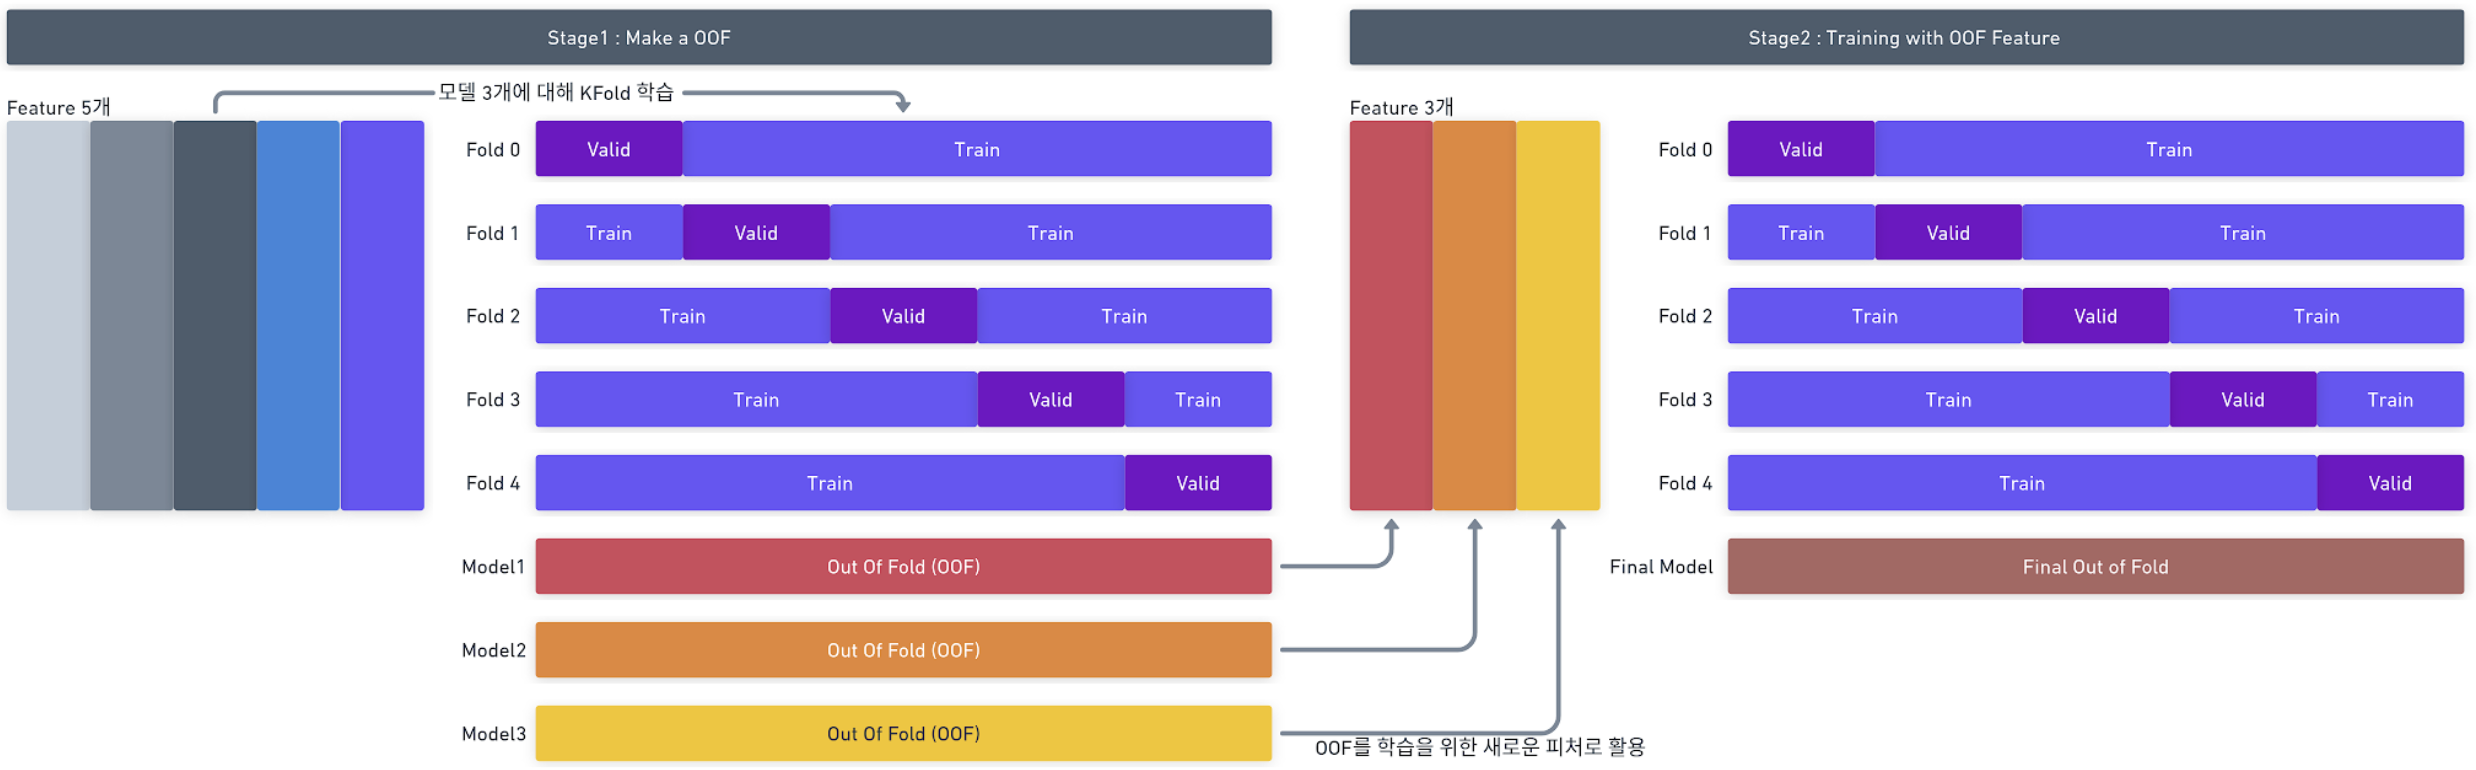

#### 👨‍💻 코드 : (2-2)

In [37]:
# 1. oofs 생성 부분 추가
# 2. 10개의 다른 seed 사용
oofs = np.zeros(len(X_train))
seeds = [i for i in range(10)] # [0~9]

all_oofs = []
all_total_predicts = []
RMSES = []

for seed in seeds:
    kf = StratifiedKFold(n_splits=5)

    cut_Y_train = pd.cut(Y_train,
                        1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                        labels=False)
    train_folds = kf.split(X_train, cut_Y_train)


    seed_oofs = np.zeros(len(X_train))
    seed_predicts = np.zeros(len(X_test))

    for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
        display(f"-------- Seed {seed}, Fold {fold_idx} --------")
        kfold_X_train = X_train.iloc[train_idx, :][features]
        kfold_Y_train = Y_train.iloc[train_idx]
        kfold_X_valid = X_train.iloc[valid_idx, :][features]
        kfold_Y_valid = Y_train.iloc[valid_idx]

        gbm = lgb.LGBMRegressor(
            n_estimators=1000,
            random_state=seed,
            subsample=0.7,
            subsample_freq=1,
            verbose=-1
        )

        gbm.fit(kfold_X_train, kfold_Y_train,
                eval_set=[(kfold_X_train, kfold_Y_train), (kfold_X_valid, kfold_Y_valid)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10),
                        lgb.log_evaluation(period=10, show_stdv=True)]
        )

        fold_predicts = gbm.predict(X_test[features])
        seed_oofs[valid_idx] = gbm.predict(kfold_X_valid)
        seed_predicts += fold_predicts / n_folds

    # RMSE를 측정
    RMSE = mean_squared_error(Y_test, seed_predicts)**0.5
    display(f"Seed {seed} Ensemble Test RMSE : {RMSE}")

    all_oofs.append(seed_oofs)
    all_total_predicts.append(seed_predicts)
    RMSES += [RMSE]

'-------- Seed 0, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 125697	training's l2: 1.57997e+10	valid_1's rmse: 134957	valid_1's l2: 1.82134e+10
[20]	training's rmse: 99686.5	training's l2: 9.93739e+09	valid_1's rmse: 107968	valid_1's l2: 1.16571e+10
[30]	training's rmse: 90396.7	training's l2: 8.17156e+09	valid_1's rmse: 98927.9	valid_1's l2: 9.78673e+09
[40]	training's rmse: 81818.9	training's l2: 6.69434e+09	valid_1's rmse: 89866.3	valid_1's l2: 8.07595e+09
[50]	training's rmse: 73946.7	training's l2: 5.46812e+09	valid_1's rmse: 83249.3	valid_1's l2: 6.93044e+09
[60]	training's rmse: 67879.8	training's l2: 4.60767e+09	valid_1's rmse: 77413.4	valid_1's l2: 5.99284e+09
[70]	training's rmse: 62567.2	training's l2: 3.91465e+09	valid_1's rmse: 72624.8	valid_1's l2: 5.27436e+09
[80]	training's rmse: 58410.2	training's l2: 3.41176e+09	valid_1's rmse: 69597.5	valid_1's l2: 4.84381e+09
[90]	training's rmse: 54534.8	training's l2: 2.97404e+09	valid_1's rmse: 66254.4	valid

'-------- Seed 0, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133055	training's l2: 1.77036e+10	valid_1's rmse: 68188.7	valid_1's l2: 4.6497e+09
[20]	training's rmse: 109314	training's l2: 1.19496e+10	valid_1's rmse: 43261.1	valid_1's l2: 1.87152e+09
[30]	training's rmse: 96083.2	training's l2: 9.23198e+09	valid_1's rmse: 40397.8	valid_1's l2: 1.63198e+09
[40]	training's rmse: 85464.8	training's l2: 7.30424e+09	valid_1's rmse: 40036.3	valid_1's l2: 1.6029e+09
[50]	training's rmse: 76455.2	training's l2: 5.8454e+09	valid_1's rmse: 37779.3	valid_1's l2: 1.42727e+09
[60]	training's rmse: 69210.6	training's l2: 4.79011e+09	valid_1's rmse: 38017.5	valid_1's l2: 1.44533e+09
Early stopping, best iteration is:
[50]	training's rmse: 76455.2	training's l2: 5.8454e+09	valid_1's rmse: 37779.3	valid_1's l2: 1.42727e+09


'-------- Seed 0, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 114462	training's l2: 1.31016e+10	valid_1's rmse: 174510	valid_1's l2: 3.04537e+10
[20]	training's rmse: 88475	training's l2: 7.82783e+09	valid_1's rmse: 148518	valid_1's l2: 2.20576e+10
[30]	training's rmse: 81204.1	training's l2: 6.5941e+09	valid_1's rmse: 139746	valid_1's l2: 1.9529e+10
[40]	training's rmse: 76087.1	training's l2: 5.78925e+09	valid_1's rmse: 131585	valid_1's l2: 1.73146e+10
[50]	training's rmse: 72265.8	training's l2: 5.22235e+09	valid_1's rmse: 126182	valid_1's l2: 1.5922e+10
[60]	training's rmse: 67913.2	training's l2: 4.6122e+09	valid_1's rmse: 118132	valid_1's l2: 1.39551e+10
[70]	training's rmse: 62823	training's l2: 3.94673e+09	valid_1's rmse: 110465	valid_1's l2: 1.22025e+10
[80]	training's rmse: 58701.2	training's l2: 3.44583e+09	valid_1's rmse: 103363	valid_1's l2: 1.06838e+10
[90]	training's rmse: 55047.3	training's l2: 3.0302e+09	valid_1's rmse: 96814.9	valid_1's l2: 9.3731

'-------- Seed 0, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 135957	training's l2: 1.84843e+10	valid_1's rmse: 96844.4	valid_1's l2: 9.37885e+09
[20]	training's rmse: 108396	training's l2: 1.17497e+10	valid_1's rmse: 76354.5	valid_1's l2: 5.83001e+09
[30]	training's rmse: 95804	training's l2: 9.1784e+09	valid_1's rmse: 72002.4	valid_1's l2: 5.18435e+09
[40]	training's rmse: 86046.1	training's l2: 7.40394e+09	valid_1's rmse: 66627.6	valid_1's l2: 4.43923e+09
[50]	training's rmse: 78351	training's l2: 6.13887e+09	valid_1's rmse: 64703.7	valid_1's l2: 4.18656e+09
[60]	training's rmse: 70692.7	training's l2: 4.99746e+09	valid_1's rmse: 61963.1	valid_1's l2: 3.83942e+09
[70]	training's rmse: 64284.9	training's l2: 4.13255e+09	valid_1's rmse: 59597.3	valid_1's l2: 3.55184e+09
[80]	training's rmse: 58379.8	training's l2: 3.4082e+09	valid_1's rmse: 58250.2	valid_1's l2: 3.39309e+09
[90]	training's rmse: 53793.2	training's l2: 2.89371e+09	valid_1's rmse: 53693.6	valid_1's 

'-------- Seed 0, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132708	training's l2: 1.76114e+10	valid_1's rmse: 148221	valid_1's l2: 2.19695e+10
[20]	training's rmse: 109034	training's l2: 1.18883e+10	valid_1's rmse: 117907	valid_1's l2: 1.39021e+10
[30]	training's rmse: 97697.3	training's l2: 9.54477e+09	valid_1's rmse: 107631	valid_1's l2: 1.15844e+10
[40]	training's rmse: 87865	training's l2: 7.72026e+09	valid_1's rmse: 99145.8	valid_1's l2: 9.82989e+09
[50]	training's rmse: 80241.4	training's l2: 6.43869e+09	valid_1's rmse: 92919.5	valid_1's l2: 8.63403e+09
[60]	training's rmse: 73634.2	training's l2: 5.422e+09	valid_1's rmse: 86267.2	valid_1's l2: 7.44203e+09
[70]	training's rmse: 68108.5	training's l2: 4.63877e+09	valid_1's rmse: 83450.6	valid_1's l2: 6.96401e+09
[80]	training's rmse: 63072.4	training's l2: 3.97813e+09	valid_1's rmse: 79093	valid_1's l2: 6.2557e+09
[90]	training's rmse: 59038.2	training's l2: 3.48551e+09	valid_1's rmse: 74824.9	valid_1's l2: 

'Seed 0 Ensemble Test RMSE : 45175.04368751635'

'-------- Seed 1, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 124535	training's l2: 1.55089e+10	valid_1's rmse: 132684	valid_1's l2: 1.7605e+10
[20]	training's rmse: 100694	training's l2: 1.01393e+10	valid_1's rmse: 108968	valid_1's l2: 1.18741e+10
[30]	training's rmse: 91257.1	training's l2: 8.32785e+09	valid_1's rmse: 98632.4	valid_1's l2: 9.72834e+09
[40]	training's rmse: 83738.4	training's l2: 7.01212e+09	valid_1's rmse: 92145.5	valid_1's l2: 8.49079e+09
[50]	training's rmse: 77019.4	training's l2: 5.93198e+09	valid_1's rmse: 85536.9	valid_1's l2: 7.31656e+09
[60]	training's rmse: 71215.5	training's l2: 5.07165e+09	valid_1's rmse: 81056.1	valid_1's l2: 6.57009e+09
[70]	training's rmse: 65710.3	training's l2: 4.31784e+09	valid_1's rmse: 76109.7	valid_1's l2: 5.79269e+09
[80]	training's rmse: 61088.1	training's l2: 3.73175e+09	valid_1's rmse: 72759.4	valid_1's l2: 5.29394e+09
[90]	training's rmse: 56468.2	training's l2: 3.18866e+09	valid_1's rmse: 67983.3	valid_1

'-------- Seed 1, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132286	training's l2: 1.74995e+10	valid_1's rmse: 67512.8	valid_1's l2: 4.55798e+09
[20]	training's rmse: 110225	training's l2: 1.21495e+10	valid_1's rmse: 43738.7	valid_1's l2: 1.91308e+09
[30]	training's rmse: 98727.1	training's l2: 9.74704e+09	valid_1's rmse: 39352.5	valid_1's l2: 1.54862e+09
[40]	training's rmse: 89584.1	training's l2: 8.02531e+09	valid_1's rmse: 37760.7	valid_1's l2: 1.42587e+09
[50]	training's rmse: 81465	training's l2: 6.63654e+09	valid_1's rmse: 37587.7	valid_1's l2: 1.41284e+09
[60]	training's rmse: 74625.5	training's l2: 5.56896e+09	valid_1's rmse: 38150.7	valid_1's l2: 1.45548e+09
Early stopping, best iteration is:
[54]	training's rmse: 78143.9	training's l2: 6.10647e+09	valid_1's rmse: 35857	valid_1's l2: 1.28572e+09


'-------- Seed 1, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 114882	training's l2: 1.3198e+10	valid_1's rmse: 174596	valid_1's l2: 3.04839e+10
[20]	training's rmse: 86651	training's l2: 7.5084e+09	valid_1's rmse: 145708	valid_1's l2: 2.12308e+10
[30]	training's rmse: 79519.1	training's l2: 6.32329e+09	valid_1's rmse: 133398	valid_1's l2: 1.7795e+10
[40]	training's rmse: 74049	training's l2: 5.48326e+09	valid_1's rmse: 126621	valid_1's l2: 1.60329e+10
[50]	training's rmse: 69407.1	training's l2: 4.81735e+09	valid_1's rmse: 122067	valid_1's l2: 1.49003e+10
[60]	training's rmse: 64905.9	training's l2: 4.21277e+09	valid_1's rmse: 115628	valid_1's l2: 1.33699e+10
[70]	training's rmse: 61405.1	training's l2: 3.77059e+09	valid_1's rmse: 109495	valid_1's l2: 1.19892e+10
[80]	training's rmse: 58145	training's l2: 3.38085e+09	valid_1's rmse: 105167	valid_1's l2: 1.106e+10
[90]	training's rmse: 54386	training's l2: 2.95784e+09	valid_1's rmse: 99823.8	valid_1's l2: 9.96479e+0

'-------- Seed 1, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 130988	training's l2: 1.7158e+10	valid_1's rmse: 92503.5	valid_1's l2: 8.55689e+09
[20]	training's rmse: 108440	training's l2: 1.17592e+10	valid_1's rmse: 79549.1	valid_1's l2: 6.32806e+09
[30]	training's rmse: 97467.8	training's l2: 9.49997e+09	valid_1's rmse: 73794.2	valid_1's l2: 5.44559e+09
[40]	training's rmse: 87709.3	training's l2: 7.69293e+09	valid_1's rmse: 65754.4	valid_1's l2: 4.32364e+09
[50]	training's rmse: 79757.7	training's l2: 6.3613e+09	valid_1's rmse: 60950.4	valid_1's l2: 3.71495e+09
[60]	training's rmse: 73578.4	training's l2: 5.41378e+09	valid_1's rmse: 56969.2	valid_1's l2: 3.24549e+09
[70]	training's rmse: 67406.4	training's l2: 4.54362e+09	valid_1's rmse: 55892.7	valid_1's l2: 3.12399e+09
[80]	training's rmse: 61525.3	training's l2: 3.78537e+09	valid_1's rmse: 53485.9	valid_1's l2: 2.86074e+09
[90]	training's rmse: 56459.4	training's l2: 3.18766e+09	valid_1's rmse: 50939.5	valid_

'-------- Seed 1, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133728	training's l2: 1.78831e+10	valid_1's rmse: 149985	valid_1's l2: 2.24956e+10
[20]	training's rmse: 111658	training's l2: 1.24675e+10	valid_1's rmse: 119531	valid_1's l2: 1.42876e+10
[30]	training's rmse: 99918.8	training's l2: 9.98376e+09	valid_1's rmse: 107526	valid_1's l2: 1.15619e+10
[40]	training's rmse: 90398.3	training's l2: 8.17185e+09	valid_1's rmse: 99190.1	valid_1's l2: 9.83867e+09
[50]	training's rmse: 82477.3	training's l2: 6.80251e+09	valid_1's rmse: 93091.2	valid_1's l2: 8.66597e+09
[60]	training's rmse: 74029.9	training's l2: 5.48043e+09	valid_1's rmse: 86408.8	valid_1's l2: 7.46648e+09
[70]	training's rmse: 68203.3	training's l2: 4.6517e+09	valid_1's rmse: 81922.1	valid_1's l2: 6.71124e+09
[80]	training's rmse: 63816.3	training's l2: 4.07252e+09	valid_1's rmse: 78115.4	valid_1's l2: 6.10201e+09
[90]	training's rmse: 58351.4	training's l2: 3.40488e+09	valid_1's rmse: 74093.1	valid_1'

'Seed 1 Ensemble Test RMSE : 45403.39176344328'

'-------- Seed 2, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 131531	training's l2: 1.73004e+10	valid_1's rmse: 139941	valid_1's l2: 1.95835e+10
[20]	training's rmse: 104926	training's l2: 1.10094e+10	valid_1's rmse: 114273	valid_1's l2: 1.30583e+10
[30]	training's rmse: 94810.4	training's l2: 8.989e+09	valid_1's rmse: 103425	valid_1's l2: 1.06967e+10
[40]	training's rmse: 85898.1	training's l2: 7.37849e+09	valid_1's rmse: 94842	valid_1's l2: 8.995e+09
[50]	training's rmse: 77343.4	training's l2: 5.98201e+09	valid_1's rmse: 85367.8	valid_1's l2: 7.28766e+09
[60]	training's rmse: 70492.1	training's l2: 4.96914e+09	valid_1's rmse: 79202.8	valid_1's l2: 6.27309e+09
[70]	training's rmse: 64897.6	training's l2: 4.2117e+09	valid_1's rmse: 73868.8	valid_1's l2: 5.4566e+09
[80]	training's rmse: 60191.6	training's l2: 3.62303e+09	valid_1's rmse: 69568	valid_1's l2: 4.83971e+09
[90]	training's rmse: 55074.1	training's l2: 3.03316e+09	valid_1's rmse: 65653.9	valid_1's l2: 4.3

'-------- Seed 2, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 135203	training's l2: 1.82799e+10	valid_1's rmse: 69923.6	valid_1's l2: 4.88931e+09
[20]	training's rmse: 109792	training's l2: 1.20543e+10	valid_1's rmse: 43649.3	valid_1's l2: 1.90526e+09
[30]	training's rmse: 94831.5	training's l2: 8.99302e+09	valid_1's rmse: 42860	valid_1's l2: 1.83698e+09
Early stopping, best iteration is:
[22]	training's rmse: 105759	training's l2: 1.1185e+10	valid_1's rmse: 40591.4	valid_1's l2: 1.64767e+09


'-------- Seed 2, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 113766	training's l2: 1.29427e+10	valid_1's rmse: 173672	valid_1's l2: 3.0162e+10
[20]	training's rmse: 87392.5	training's l2: 7.63745e+09	valid_1's rmse: 146810	valid_1's l2: 2.15531e+10
[30]	training's rmse: 79239	training's l2: 6.27882e+09	valid_1's rmse: 132984	valid_1's l2: 1.76847e+10
[40]	training's rmse: 72985.9	training's l2: 5.32695e+09	valid_1's rmse: 126919	valid_1's l2: 1.61084e+10
[50]	training's rmse: 69014.8	training's l2: 4.76305e+09	valid_1's rmse: 123126	valid_1's l2: 1.51599e+10
[60]	training's rmse: 64513.2	training's l2: 4.16195e+09	valid_1's rmse: 114551	valid_1's l2: 1.3122e+10
[70]	training's rmse: 61271.8	training's l2: 3.75424e+09	valid_1's rmse: 110816	valid_1's l2: 1.22802e+10
[80]	training's rmse: 57539.5	training's l2: 3.31079e+09	valid_1's rmse: 105957	valid_1's l2: 1.12269e+10
[90]	training's rmse: 54503.9	training's l2: 2.97067e+09	valid_1's rmse: 102923	valid_1's l2: 1.

'-------- Seed 2, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132024	training's l2: 1.74303e+10	valid_1's rmse: 93582.8	valid_1's l2: 8.75774e+09
[20]	training's rmse: 105965	training's l2: 1.12287e+10	valid_1's rmse: 73213.5	valid_1's l2: 5.36022e+09
[30]	training's rmse: 94895	training's l2: 9.00505e+09	valid_1's rmse: 71534.2	valid_1's l2: 5.11715e+09
[40]	training's rmse: 85249.2	training's l2: 7.26743e+09	valid_1's rmse: 65195.6	valid_1's l2: 4.25047e+09
[50]	training's rmse: 77237.7	training's l2: 5.96566e+09	valid_1's rmse: 58955.4	valid_1's l2: 3.47574e+09
[60]	training's rmse: 70256.8	training's l2: 4.93601e+09	valid_1's rmse: 56382.9	valid_1's l2: 3.17903e+09
[70]	training's rmse: 64988.3	training's l2: 4.22348e+09	valid_1's rmse: 54424.1	valid_1's l2: 2.96198e+09
[80]	training's rmse: 59491.7	training's l2: 3.53927e+09	valid_1's rmse: 52496.3	valid_1's l2: 2.75586e+09
[90]	training's rmse: 54309	training's l2: 2.94947e+09	valid_1's rmse: 51626.2	valid_1'

'-------- Seed 2, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132247	training's l2: 1.74892e+10	valid_1's rmse: 148497	valid_1's l2: 2.20514e+10
[20]	training's rmse: 109028	training's l2: 1.18872e+10	valid_1's rmse: 118145	valid_1's l2: 1.39583e+10
[30]	training's rmse: 99549.4	training's l2: 9.91008e+09	valid_1's rmse: 109806	valid_1's l2: 1.20573e+10
[40]	training's rmse: 89639	training's l2: 8.03516e+09	valid_1's rmse: 99905.6	valid_1's l2: 9.98114e+09
[50]	training's rmse: 81903	training's l2: 6.7081e+09	valid_1's rmse: 93740.2	valid_1's l2: 8.78722e+09
[60]	training's rmse: 76263.8	training's l2: 5.81617e+09	valid_1's rmse: 89100.5	valid_1's l2: 7.9389e+09
[70]	training's rmse: 69753.1	training's l2: 4.86549e+09	valid_1's rmse: 82684.4	valid_1's l2: 6.83671e+09
[80]	training's rmse: 64456	training's l2: 4.15458e+09	valid_1's rmse: 78182	valid_1's l2: 6.11242e+09
[90]	training's rmse: 60228.8	training's l2: 3.6275e+09	valid_1's rmse: 74893	valid_1's l2: 5.6089

'Seed 2 Ensemble Test RMSE : 48558.52472708284'

'-------- Seed 3, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 127810	training's l2: 1.63355e+10	valid_1's rmse: 135879	valid_1's l2: 1.84632e+10
[20]	training's rmse: 105824	training's l2: 1.11988e+10	valid_1's rmse: 116299	valid_1's l2: 1.35256e+10
[30]	training's rmse: 95598.2	training's l2: 9.13901e+09	valid_1's rmse: 105120	valid_1's l2: 1.10503e+10
[40]	training's rmse: 85469.1	training's l2: 7.30497e+09	valid_1's rmse: 95752.6	valid_1's l2: 9.16857e+09
[50]	training's rmse: 77280.7	training's l2: 5.97231e+09	valid_1's rmse: 87039.9	valid_1's l2: 7.57595e+09
[60]	training's rmse: 72362.3	training's l2: 5.2363e+09	valid_1's rmse: 81537.4	valid_1's l2: 6.64834e+09
[70]	training's rmse: 66784.8	training's l2: 4.46021e+09	valid_1's rmse: 75251.3	valid_1's l2: 5.66276e+09
[80]	training's rmse: 61393	training's l2: 3.7691e+09	valid_1's rmse: 70790.6	valid_1's l2: 5.0113e+09
[90]	training's rmse: 56220.5	training's l2: 3.16075e+09	valid_1's rmse: 66418.1	valid_1's l2

'-------- Seed 3, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 136006	training's l2: 1.84975e+10	valid_1's rmse: 73248.4	valid_1's l2: 5.36532e+09
[20]	training's rmse: 108939	training's l2: 1.18677e+10	valid_1's rmse: 46347	valid_1's l2: 2.14804e+09
[30]	training's rmse: 97112.6	training's l2: 9.43086e+09	valid_1's rmse: 43826.9	valid_1's l2: 1.9208e+09
[40]	training's rmse: 88030.4	training's l2: 7.74934e+09	valid_1's rmse: 40523.4	valid_1's l2: 1.64215e+09
Early stopping, best iteration is:
[37]	training's rmse: 90605.1	training's l2: 8.20929e+09	valid_1's rmse: 39969.9	valid_1's l2: 1.59759e+09


'-------- Seed 3, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 115555	training's l2: 1.3353e+10	valid_1's rmse: 174926	valid_1's l2: 3.05989e+10
[20]	training's rmse: 88235.8	training's l2: 7.78555e+09	valid_1's rmse: 148353	valid_1's l2: 2.20087e+10
[30]	training's rmse: 80831.2	training's l2: 6.53368e+09	valid_1's rmse: 137609	valid_1's l2: 1.89363e+10
[40]	training's rmse: 74397.8	training's l2: 5.53503e+09	valid_1's rmse: 126993	valid_1's l2: 1.61272e+10
[50]	training's rmse: 69089.8	training's l2: 4.7734e+09	valid_1's rmse: 119635	valid_1's l2: 1.43124e+10
[60]	training's rmse: 64960.2	training's l2: 4.21983e+09	valid_1's rmse: 113552	valid_1's l2: 1.28941e+10
[70]	training's rmse: 60809.1	training's l2: 3.69775e+09	valid_1's rmse: 108799	valid_1's l2: 1.18373e+10
[80]	training's rmse: 58096.9	training's l2: 3.37525e+09	valid_1's rmse: 105622	valid_1's l2: 1.1156e+10
[90]	training's rmse: 55059.8	training's l2: 3.03158e+09	valid_1's rmse: 101648	valid_1's l2: 1

'-------- Seed 3, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 136971	training's l2: 1.8761e+10	valid_1's rmse: 98015.1	valid_1's l2: 9.60696e+09
[20]	training's rmse: 109154	training's l2: 1.19147e+10	valid_1's rmse: 75537.7	valid_1's l2: 5.70595e+09
[30]	training's rmse: 98053.1	training's l2: 9.6144e+09	valid_1's rmse: 71973.8	valid_1's l2: 5.18022e+09
[40]	training's rmse: 87150.1	training's l2: 7.59514e+09	valid_1's rmse: 63479.4	valid_1's l2: 4.02963e+09
[50]	training's rmse: 78659.8	training's l2: 6.18736e+09	valid_1's rmse: 58323.4	valid_1's l2: 3.40162e+09
[60]	training's rmse: 71007.8	training's l2: 5.04211e+09	valid_1's rmse: 53938.3	valid_1's l2: 2.90933e+09
[70]	training's rmse: 65863.1	training's l2: 4.33795e+09	valid_1's rmse: 52015.4	valid_1's l2: 2.70561e+09
[80]	training's rmse: 61433.3	training's l2: 3.77405e+09	valid_1's rmse: 49776.3	valid_1's l2: 2.47768e+09
[90]	training's rmse: 58363.6	training's l2: 3.40631e+09	valid_1's rmse: 46728.9	valid_

'-------- Seed 3, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133612	training's l2: 1.78521e+10	valid_1's rmse: 149490	valid_1's l2: 2.23473e+10
[20]	training's rmse: 111141	training's l2: 1.23524e+10	valid_1's rmse: 119823	valid_1's l2: 1.43576e+10
[30]	training's rmse: 100056	training's l2: 1.00111e+10	valid_1's rmse: 109306	valid_1's l2: 1.19479e+10
[40]	training's rmse: 89619.7	training's l2: 8.0317e+09	valid_1's rmse: 99428.6	valid_1's l2: 9.88604e+09
[50]	training's rmse: 82104.5	training's l2: 6.74115e+09	valid_1's rmse: 92969.3	valid_1's l2: 8.64328e+09
[60]	training's rmse: 73865.3	training's l2: 5.45609e+09	valid_1's rmse: 85620.3	valid_1's l2: 7.33084e+09
[70]	training's rmse: 67921.7	training's l2: 4.61336e+09	valid_1's rmse: 80703	valid_1's l2: 6.51297e+09
[80]	training's rmse: 62124.9	training's l2: 3.8595e+09	valid_1's rmse: 76011.2	valid_1's l2: 5.7777e+09
[90]	training's rmse: 58284.9	training's l2: 3.39712e+09	valid_1's rmse: 72673.4	valid_1's l2:

'Seed 3 Ensemble Test RMSE : 49232.42458614678'

'-------- Seed 4, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 126854	training's l2: 1.60919e+10	valid_1's rmse: 134866	valid_1's l2: 1.81889e+10
[20]	training's rmse: 101907	training's l2: 1.0385e+10	valid_1's rmse: 110327	valid_1's l2: 1.21721e+10
[30]	training's rmse: 89781.8	training's l2: 8.06078e+09	valid_1's rmse: 98093	valid_1's l2: 9.62224e+09
[40]	training's rmse: 82851.2	training's l2: 6.86433e+09	valid_1's rmse: 91310.8	valid_1's l2: 8.33767e+09
[50]	training's rmse: 75934.4	training's l2: 5.76604e+09	valid_1's rmse: 85309.9	valid_1's l2: 7.27779e+09
[60]	training's rmse: 69978	training's l2: 4.89692e+09	valid_1's rmse: 81343.4	valid_1's l2: 6.61675e+09
[70]	training's rmse: 65654.5	training's l2: 4.31051e+09	valid_1's rmse: 77569.6	valid_1's l2: 6.01704e+09
[80]	training's rmse: 60825.9	training's l2: 3.69979e+09	valid_1's rmse: 72641.4	valid_1's l2: 5.27677e+09
[90]	training's rmse: 56701.9	training's l2: 3.21511e+09	valid_1's rmse: 68563.9	valid_1's l

'-------- Seed 4, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 131656	training's l2: 1.73332e+10	valid_1's rmse: 66999.6	valid_1's l2: 4.48895e+09
[20]	training's rmse: 107152	training's l2: 1.14816e+10	valid_1's rmse: 43095.1	valid_1's l2: 1.85719e+09
[30]	training's rmse: 97640.8	training's l2: 9.53372e+09	valid_1's rmse: 40671.1	valid_1's l2: 1.65414e+09
[40]	training's rmse: 90214.9	training's l2: 8.13874e+09	valid_1's rmse: 38705.1	valid_1's l2: 1.49808e+09
[50]	training's rmse: 80958.6	training's l2: 6.55429e+09	valid_1's rmse: 41030.5	valid_1's l2: 1.6835e+09
Early stopping, best iteration is:
[40]	training's rmse: 90214.9	training's l2: 8.13874e+09	valid_1's rmse: 38705.1	valid_1's l2: 1.49808e+09


'-------- Seed 4, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 114310	training's l2: 1.30668e+10	valid_1's rmse: 173739	valid_1's l2: 3.01851e+10
[20]	training's rmse: 87986.5	training's l2: 7.74162e+09	valid_1's rmse: 149044	valid_1's l2: 2.22141e+10
[30]	training's rmse: 80503.9	training's l2: 6.48087e+09	valid_1's rmse: 137219	valid_1's l2: 1.8829e+10
[40]	training's rmse: 74844.6	training's l2: 5.60171e+09	valid_1's rmse: 129104	valid_1's l2: 1.66678e+10
[50]	training's rmse: 69542.4	training's l2: 4.83614e+09	valid_1's rmse: 122661	valid_1's l2: 1.50457e+10
[60]	training's rmse: 65203.2	training's l2: 4.25146e+09	valid_1's rmse: 116224	valid_1's l2: 1.3508e+10
[70]	training's rmse: 62276.6	training's l2: 3.87837e+09	valid_1's rmse: 112623	valid_1's l2: 1.2684e+10
[80]	training's rmse: 59138.8	training's l2: 3.49739e+09	valid_1's rmse: 108490	valid_1's l2: 1.17701e+10
[90]	training's rmse: 55727.9	training's l2: 3.1056e+09	valid_1's rmse: 102900	valid_1's l2: 1.

'-------- Seed 4, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133555	training's l2: 1.78369e+10	valid_1's rmse: 94882.2	valid_1's l2: 9.00264e+09
[20]	training's rmse: 111341	training's l2: 1.23969e+10	valid_1's rmse: 79755.9	valid_1's l2: 6.361e+09
[30]	training's rmse: 99293.7	training's l2: 9.85924e+09	valid_1's rmse: 74852.6	valid_1's l2: 5.60291e+09
[40]	training's rmse: 88180.2	training's l2: 7.77575e+09	valid_1's rmse: 67938.9	valid_1's l2: 4.6157e+09
[50]	training's rmse: 80797.8	training's l2: 6.52829e+09	valid_1's rmse: 66740	valid_1's l2: 4.45423e+09
[60]	training's rmse: 72516.3	training's l2: 5.25862e+09	valid_1's rmse: 61763.5	valid_1's l2: 3.81473e+09
[70]	training's rmse: 66738.7	training's l2: 4.45405e+09	valid_1's rmse: 57041.9	valid_1's l2: 3.25378e+09
[80]	training's rmse: 61606	training's l2: 3.7953e+09	valid_1's rmse: 54552.1	valid_1's l2: 2.97593e+09
[90]	training's rmse: 56048.2	training's l2: 3.1414e+09	valid_1's rmse: 52319.2	valid_1's l2:

'-------- Seed 4, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 134476	training's l2: 1.80838e+10	valid_1's rmse: 151690	valid_1's l2: 2.30099e+10
[20]	training's rmse: 111021	training's l2: 1.23256e+10	valid_1's rmse: 118768	valid_1's l2: 1.41057e+10
[30]	training's rmse: 99812.7	training's l2: 9.96258e+09	valid_1's rmse: 108268	valid_1's l2: 1.17221e+10
[40]	training's rmse: 90086.1	training's l2: 8.1155e+09	valid_1's rmse: 97604.8	valid_1's l2: 9.52669e+09
[50]	training's rmse: 82258	training's l2: 6.76638e+09	valid_1's rmse: 90498.4	valid_1's l2: 8.18996e+09
[60]	training's rmse: 76259.9	training's l2: 5.81558e+09	valid_1's rmse: 84953.1	valid_1's l2: 7.21703e+09
[70]	training's rmse: 70374.4	training's l2: 4.95255e+09	valid_1's rmse: 81070	valid_1's l2: 6.57234e+09
[80]	training's rmse: 64671.5	training's l2: 4.1824e+09	valid_1's rmse: 76912	valid_1's l2: 5.91546e+09
[90]	training's rmse: 59144.8	training's l2: 3.49811e+09	valid_1's rmse: 71100.4	valid_1's l2: 5

'Seed 4 Ensemble Test RMSE : 47282.08227201316'

'-------- Seed 5, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 122370	training's l2: 1.49744e+10	valid_1's rmse: 130388	valid_1's l2: 1.7001e+10
[20]	training's rmse: 98922.8	training's l2: 9.78572e+09	valid_1's rmse: 107833	valid_1's l2: 1.1628e+10
[30]	training's rmse: 88850.8	training's l2: 7.89446e+09	valid_1's rmse: 96738.4	valid_1's l2: 9.35833e+09
[40]	training's rmse: 81028.7	training's l2: 6.56564e+09	valid_1's rmse: 89393.9	valid_1's l2: 7.99128e+09
[50]	training's rmse: 74344.6	training's l2: 5.52712e+09	valid_1's rmse: 83206.2	valid_1's l2: 6.92326e+09
[60]	training's rmse: 68876.1	training's l2: 4.74392e+09	valid_1's rmse: 77946.2	valid_1's l2: 6.0756e+09
[70]	training's rmse: 63490.5	training's l2: 4.03105e+09	valid_1's rmse: 73416	valid_1's l2: 5.3899e+09
[80]	training's rmse: 58531.5	training's l2: 3.42594e+09	valid_1's rmse: 69169.3	valid_1's l2: 4.78439e+09
[90]	training's rmse: 54749.6	training's l2: 2.99752e+09	valid_1's rmse: 65619.9	valid_1's l

'-------- Seed 5, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132937	training's l2: 1.76722e+10	valid_1's rmse: 68122.1	valid_1's l2: 4.64062e+09
[20]	training's rmse: 106183	training's l2: 1.12748e+10	valid_1's rmse: 42909.6	valid_1's l2: 1.84123e+09
[30]	training's rmse: 95813.2	training's l2: 9.18017e+09	valid_1's rmse: 44850.4	valid_1's l2: 2.01156e+09
Early stopping, best iteration is:
[20]	training's rmse: 106183	training's l2: 1.12748e+10	valid_1's rmse: 42909.6	valid_1's l2: 1.84123e+09


'-------- Seed 5, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 115022	training's l2: 1.32301e+10	valid_1's rmse: 174596	valid_1's l2: 3.04836e+10
[20]	training's rmse: 85569.3	training's l2: 7.3221e+09	valid_1's rmse: 145452	valid_1's l2: 2.11562e+10
[30]	training's rmse: 79277	training's l2: 6.28484e+09	valid_1's rmse: 135243	valid_1's l2: 1.82908e+10
[40]	training's rmse: 74476	training's l2: 5.54667e+09	valid_1's rmse: 130660	valid_1's l2: 1.70719e+10
[50]	training's rmse: 70391.8	training's l2: 4.95501e+09	valid_1's rmse: 125437	valid_1's l2: 1.57346e+10
[60]	training's rmse: 66866.4	training's l2: 4.47111e+09	valid_1's rmse: 118684	valid_1's l2: 1.40858e+10
[70]	training's rmse: 61517	training's l2: 3.78434e+09	valid_1's rmse: 109858	valid_1's l2: 1.20687e+10
[80]	training's rmse: 58555.9	training's l2: 3.4288e+09	valid_1's rmse: 106269	valid_1's l2: 1.12931e+10
[90]	training's rmse: 55629.6	training's l2: 3.09465e+09	valid_1's rmse: 104006	valid_1's l2: 1.0817

'-------- Seed 5, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133215	training's l2: 1.77463e+10	valid_1's rmse: 94749.9	valid_1's l2: 8.97755e+09
[20]	training's rmse: 106547	training's l2: 1.13524e+10	valid_1's rmse: 76244.4	valid_1's l2: 5.81321e+09
[30]	training's rmse: 97286.7	training's l2: 9.46469e+09	valid_1's rmse: 72093.2	valid_1's l2: 5.19742e+09
[40]	training's rmse: 89161.5	training's l2: 7.94978e+09	valid_1's rmse: 66866.4	valid_1's l2: 4.47111e+09
[50]	training's rmse: 81985.9	training's l2: 6.72169e+09	valid_1's rmse: 64127.6	valid_1's l2: 4.11234e+09
[60]	training's rmse: 74982.6	training's l2: 5.62239e+09	valid_1's rmse: 60237.4	valid_1's l2: 3.62854e+09
[70]	training's rmse: 68028.2	training's l2: 4.62783e+09	valid_1's rmse: 59041.7	valid_1's l2: 3.48592e+09
[80]	training's rmse: 62486.8	training's l2: 3.9046e+09	valid_1's rmse: 56124.2	valid_1's l2: 3.14993e+09
[90]	training's rmse: 58192.7	training's l2: 3.38639e+09	valid_1's rmse: 54689	valid_1

'-------- Seed 5, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 130371	training's l2: 1.69966e+10	valid_1's rmse: 146141	valid_1's l2: 2.13572e+10
[20]	training's rmse: 107060	training's l2: 1.14619e+10	valid_1's rmse: 116800	valid_1's l2: 1.36422e+10
[30]	training's rmse: 94698.9	training's l2: 8.96787e+09	valid_1's rmse: 104504	valid_1's l2: 1.0921e+10
[40]	training's rmse: 85274.6	training's l2: 7.27175e+09	valid_1's rmse: 97125.3	valid_1's l2: 9.43332e+09
[50]	training's rmse: 77777.9	training's l2: 6.0494e+09	valid_1's rmse: 90528.9	valid_1's l2: 8.19548e+09
[60]	training's rmse: 72663.6	training's l2: 5.28e+09	valid_1's rmse: 87550.5	valid_1's l2: 7.66508e+09
[70]	training's rmse: 67037	training's l2: 4.49395e+09	valid_1's rmse: 83397.7	valid_1's l2: 6.95517e+09
[80]	training's rmse: 61348.9	training's l2: 3.76369e+09	valid_1's rmse: 78369.7	valid_1's l2: 6.14182e+09
[90]	training's rmse: 55740.4	training's l2: 3.10699e+09	valid_1's rmse: 74858.2	valid_1's l2: 

'Seed 5 Ensemble Test RMSE : 47318.20597415634'

'-------- Seed 6, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 131891	training's l2: 1.73953e+10	valid_1's rmse: 140169	valid_1's l2: 1.96473e+10
[20]	training's rmse: 106197	training's l2: 1.12777e+10	valid_1's rmse: 115187	valid_1's l2: 1.32679e+10
[30]	training's rmse: 94629.5	training's l2: 8.95475e+09	valid_1's rmse: 102268	valid_1's l2: 1.04587e+10
[40]	training's rmse: 85077	training's l2: 7.2381e+09	valid_1's rmse: 93289.6	valid_1's l2: 8.70295e+09
[50]	training's rmse: 76708.8	training's l2: 5.88424e+09	valid_1's rmse: 85666.7	valid_1's l2: 7.33879e+09
[60]	training's rmse: 70715.9	training's l2: 5.00073e+09	valid_1's rmse: 78673.1	valid_1's l2: 6.18945e+09
[70]	training's rmse: 64257.4	training's l2: 4.12902e+09	valid_1's rmse: 72494	valid_1's l2: 5.25538e+09
[80]	training's rmse: 60025.3	training's l2: 3.60303e+09	valid_1's rmse: 70223.9	valid_1's l2: 4.9314e+09
[90]	training's rmse: 54717	training's l2: 2.99395e+09	valid_1's rmse: 65034	valid_1's l2: 4.2

'-------- Seed 6, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 134631	training's l2: 1.81255e+10	valid_1's rmse: 69331.5	valid_1's l2: 4.80685e+09
[20]	training's rmse: 108722	training's l2: 1.18204e+10	valid_1's rmse: 45219.3	valid_1's l2: 2.04479e+09
[30]	training's rmse: 95808.4	training's l2: 9.17924e+09	valid_1's rmse: 41306.5	valid_1's l2: 1.70623e+09
[40]	training's rmse: 87729.7	training's l2: 7.69651e+09	valid_1's rmse: 41034.6	valid_1's l2: 1.68384e+09
Early stopping, best iteration is:
[35]	training's rmse: 92984.5	training's l2: 8.64611e+09	valid_1's rmse: 40071.7	valid_1's l2: 1.60574e+09


'-------- Seed 6, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 113209	training's l2: 1.28162e+10	valid_1's rmse: 173076	valid_1's l2: 2.99552e+10
[20]	training's rmse: 86236	training's l2: 7.43666e+09	valid_1's rmse: 145626	valid_1's l2: 2.1207e+10
[30]	training's rmse: 78648	training's l2: 6.18551e+09	valid_1's rmse: 135896	valid_1's l2: 1.84678e+10
[40]	training's rmse: 73843.7	training's l2: 5.45289e+09	valid_1's rmse: 129716	valid_1's l2: 1.68262e+10
[50]	training's rmse: 68881.4	training's l2: 4.74464e+09	valid_1's rmse: 123368	valid_1's l2: 1.52197e+10
[60]	training's rmse: 65981.3	training's l2: 4.35354e+09	valid_1's rmse: 120847	valid_1's l2: 1.46041e+10
[70]	training's rmse: 61016.2	training's l2: 3.72297e+09	valid_1's rmse: 112666	valid_1's l2: 1.26936e+10
[80]	training's rmse: 57261.9	training's l2: 3.27893e+09	valid_1's rmse: 108073	valid_1's l2: 1.16797e+10
[90]	training's rmse: 54159.8	training's l2: 2.93329e+09	valid_1's rmse: 102838	valid_1's l2: 1.0

'-------- Seed 6, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132618	training's l2: 1.75876e+10	valid_1's rmse: 94444.9	valid_1's l2: 8.91984e+09
[20]	training's rmse: 106954	training's l2: 1.14392e+10	valid_1's rmse: 77425	valid_1's l2: 5.99463e+09
[30]	training's rmse: 94868.4	training's l2: 9.00001e+09	valid_1's rmse: 73287.6	valid_1's l2: 5.37107e+09
[40]	training's rmse: 86030	training's l2: 7.40116e+09	valid_1's rmse: 69396.5	valid_1's l2: 4.81588e+09
[50]	training's rmse: 79072.5	training's l2: 6.25246e+09	valid_1's rmse: 65635.1	valid_1's l2: 4.30796e+09
[60]	training's rmse: 73951.2	training's l2: 5.46878e+09	valid_1's rmse: 64672.8	valid_1's l2: 4.18257e+09
[70]	training's rmse: 68104.1	training's l2: 4.63817e+09	valid_1's rmse: 62481.8	valid_1's l2: 3.90397e+09
[80]	training's rmse: 62651.7	training's l2: 3.92524e+09	valid_1's rmse: 58486.4	valid_1's l2: 3.42066e+09
[90]	training's rmse: 58698.7	training's l2: 3.44553e+09	valid_1's rmse: 56451.7	valid_1'

'-------- Seed 6, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133922	training's l2: 1.7935e+10	valid_1's rmse: 150466	valid_1's l2: 2.264e+10
[20]	training's rmse: 109154	training's l2: 1.19147e+10	valid_1's rmse: 117199	valid_1's l2: 1.37355e+10
[30]	training's rmse: 99458.9	training's l2: 9.89207e+09	valid_1's rmse: 109230	valid_1's l2: 1.19311e+10
[40]	training's rmse: 89251.4	training's l2: 7.96582e+09	valid_1's rmse: 99712.1	valid_1's l2: 9.94249e+09
[50]	training's rmse: 80233.1	training's l2: 6.43736e+09	valid_1's rmse: 93799.8	valid_1's l2: 8.79841e+09
[60]	training's rmse: 73821.6	training's l2: 5.44963e+09	valid_1's rmse: 87290.2	valid_1's l2: 7.61959e+09
[70]	training's rmse: 67382.6	training's l2: 4.54041e+09	valid_1's rmse: 82586.9	valid_1's l2: 6.8206e+09
[80]	training's rmse: 61130.5	training's l2: 3.73694e+09	valid_1's rmse: 77427.1	valid_1's l2: 5.99496e+09
[90]	training's rmse: 56139.3	training's l2: 3.15162e+09	valid_1's rmse: 74333.9	valid_1's l

'Seed 6 Ensemble Test RMSE : 48571.7980020287'

'-------- Seed 7, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 126904	training's l2: 1.61045e+10	valid_1's rmse: 134760	valid_1's l2: 1.81601e+10
[20]	training's rmse: 103484	training's l2: 1.07089e+10	valid_1's rmse: 112007	valid_1's l2: 1.25455e+10
[30]	training's rmse: 92217.2	training's l2: 8.50401e+09	valid_1's rmse: 100650	valid_1's l2: 1.01304e+10
[40]	training's rmse: 84497	training's l2: 7.13973e+09	valid_1's rmse: 92651.5	valid_1's l2: 8.58429e+09
[50]	training's rmse: 77488.9	training's l2: 6.00453e+09	valid_1's rmse: 85259.9	valid_1's l2: 7.26925e+09
[60]	training's rmse: 70505.9	training's l2: 4.97108e+09	valid_1's rmse: 78650.5	valid_1's l2: 6.18591e+09
[70]	training's rmse: 65125.1	training's l2: 4.24127e+09	valid_1's rmse: 75294.9	valid_1's l2: 5.66933e+09
[80]	training's rmse: 60335.7	training's l2: 3.6404e+09	valid_1's rmse: 70800.2	valid_1's l2: 5.01267e+09
[90]	training's rmse: 55790	training's l2: 3.11252e+09	valid_1's rmse: 66634.9	valid_1's l2

'-------- Seed 7, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 134422	training's l2: 1.80692e+10	valid_1's rmse: 69358	valid_1's l2: 4.81053e+09
[20]	training's rmse: 110599	training's l2: 1.22321e+10	valid_1's rmse: 43936	valid_1's l2: 1.93037e+09
[30]	training's rmse: 98872.7	training's l2: 9.77581e+09	valid_1's rmse: 40515.4	valid_1's l2: 1.6415e+09
[40]	training's rmse: 89698.2	training's l2: 8.04577e+09	valid_1's rmse: 41548.4	valid_1's l2: 1.72627e+09
[50]	training's rmse: 81769.3	training's l2: 6.68622e+09	valid_1's rmse: 39591.8	valid_1's l2: 1.56751e+09
[60]	training's rmse: 73897.5	training's l2: 5.46084e+09	valid_1's rmse: 37773.5	valid_1's l2: 1.42684e+09
[70]	training's rmse: 66876.3	training's l2: 4.47245e+09	valid_1's rmse: 39155.4	valid_1's l2: 1.53314e+09
Early stopping, best iteration is:
[66]	training's rmse: 69255.1	training's l2: 4.79626e+09	valid_1's rmse: 37623.4	valid_1's l2: 1.41552e+09


'-------- Seed 7, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 116675	training's l2: 1.3613e+10	valid_1's rmse: 176136	valid_1's l2: 3.10239e+10
[20]	training's rmse: 89436.1	training's l2: 7.99882e+09	valid_1's rmse: 149957	valid_1's l2: 2.24872e+10
[30]	training's rmse: 82848.3	training's l2: 6.86384e+09	valid_1's rmse: 139981	valid_1's l2: 1.95947e+10
[40]	training's rmse: 76057.8	training's l2: 5.78479e+09	valid_1's rmse: 130652	valid_1's l2: 1.707e+10
[50]	training's rmse: 70957.1	training's l2: 5.03491e+09	valid_1's rmse: 123668	valid_1's l2: 1.52938e+10
[60]	training's rmse: 66681.9	training's l2: 4.44648e+09	valid_1's rmse: 117092	valid_1's l2: 1.37106e+10
[70]	training's rmse: 62261.9	training's l2: 3.87655e+09	valid_1's rmse: 110668	valid_1's l2: 1.22473e+10
[80]	training's rmse: 59172.3	training's l2: 3.50136e+09	valid_1's rmse: 105199	valid_1's l2: 1.10669e+10
[90]	training's rmse: 56266.8	training's l2: 3.16596e+09	valid_1's rmse: 101554	valid_1's l2: 1

'-------- Seed 7, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 132448	training's l2: 1.75424e+10	valid_1's rmse: 93183.9	valid_1's l2: 8.68325e+09
[20]	training's rmse: 107842	training's l2: 1.16299e+10	valid_1's rmse: 74016.3	valid_1's l2: 5.47841e+09
[30]	training's rmse: 96632	training's l2: 9.33775e+09	valid_1's rmse: 69001.6	valid_1's l2: 4.76122e+09
[40]	training's rmse: 86584.3	training's l2: 7.49685e+09	valid_1's rmse: 66455.9	valid_1's l2: 4.41639e+09
[50]	training's rmse: 79648.3	training's l2: 6.34385e+09	valid_1's rmse: 61512.6	valid_1's l2: 3.78379e+09
[60]	training's rmse: 73001.3	training's l2: 5.32918e+09	valid_1's rmse: 62215.7	valid_1's l2: 3.8708e+09
Early stopping, best iteration is:
[50]	training's rmse: 79648.3	training's l2: 6.34385e+09	valid_1's rmse: 61512.6	valid_1's l2: 3.78379e+09


'-------- Seed 7, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 130793	training's l2: 1.71069e+10	valid_1's rmse: 147143	valid_1's l2: 2.1651e+10
[20]	training's rmse: 108363	training's l2: 1.17426e+10	valid_1's rmse: 118829	valid_1's l2: 1.41204e+10
[30]	training's rmse: 99033.7	training's l2: 9.80767e+09	valid_1's rmse: 110968	valid_1's l2: 1.23139e+10
[40]	training's rmse: 90283.8	training's l2: 8.15117e+09	valid_1's rmse: 101937	valid_1's l2: 1.03912e+10
[50]	training's rmse: 83119.8	training's l2: 6.9089e+09	valid_1's rmse: 95249.4	valid_1's l2: 9.07244e+09
[60]	training's rmse: 75921.7	training's l2: 5.7641e+09	valid_1's rmse: 90276.9	valid_1's l2: 8.14992e+09
[70]	training's rmse: 71283.3	training's l2: 5.08131e+09	valid_1's rmse: 86517.3	valid_1's l2: 7.48524e+09
[80]	training's rmse: 65630.5	training's l2: 4.30736e+09	valid_1's rmse: 81865.1	valid_1's l2: 6.70189e+09
[90]	training's rmse: 60174.7	training's l2: 3.62099e+09	valid_1's rmse: 78429.7	valid_1's l

'Seed 7 Ensemble Test RMSE : 50599.97712685912'

'-------- Seed 8, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 127416	training's l2: 1.62348e+10	valid_1's rmse: 135500	valid_1's l2: 1.83603e+10
[20]	training's rmse: 103659	training's l2: 1.07451e+10	valid_1's rmse: 111579	valid_1's l2: 1.24498e+10
[30]	training's rmse: 91840.5	training's l2: 8.43468e+09	valid_1's rmse: 100196	valid_1's l2: 1.00392e+10
[40]	training's rmse: 82423.6	training's l2: 6.79364e+09	valid_1's rmse: 91131.7	valid_1's l2: 8.30499e+09
[50]	training's rmse: 76554.6	training's l2: 5.86061e+09	valid_1's rmse: 86034.1	valid_1's l2: 7.40187e+09
[60]	training's rmse: 70127.7	training's l2: 4.9179e+09	valid_1's rmse: 80037.9	valid_1's l2: 6.40607e+09
[70]	training's rmse: 64809.1	training's l2: 4.20022e+09	valid_1's rmse: 75859.7	valid_1's l2: 5.7547e+09
[80]	training's rmse: 60404.1	training's l2: 3.64865e+09	valid_1's rmse: 72730.5	valid_1's l2: 5.28972e+09
[90]	training's rmse: 56437.9	training's l2: 3.18524e+09	valid_1's rmse: 69315.1	valid_1's

'-------- Seed 8, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133571	training's l2: 1.78411e+10	valid_1's rmse: 70227.9	valid_1's l2: 4.93196e+09
[20]	training's rmse: 108149	training's l2: 1.16962e+10	valid_1's rmse: 43037.3	valid_1's l2: 1.85221e+09
[30]	training's rmse: 96441.4	training's l2: 9.30094e+09	valid_1's rmse: 43560.4	valid_1's l2: 1.89751e+09
Early stopping, best iteration is:
[22]	training's rmse: 104729	training's l2: 1.09681e+10	valid_1's rmse: 41485.2	valid_1's l2: 1.72102e+09


'-------- Seed 8, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 113877	training's l2: 1.29679e+10	valid_1's rmse: 173736	valid_1's l2: 3.01844e+10
[20]	training's rmse: 87477.2	training's l2: 7.65226e+09	valid_1's rmse: 147733	valid_1's l2: 2.18251e+10
[30]	training's rmse: 78416.2	training's l2: 6.1491e+09	valid_1's rmse: 133697	valid_1's l2: 1.78748e+10
[40]	training's rmse: 73401.1	training's l2: 5.38772e+09	valid_1's rmse: 125675	valid_1's l2: 1.57941e+10
[50]	training's rmse: 67774.5	training's l2: 4.59339e+09	valid_1's rmse: 116355	valid_1's l2: 1.35386e+10
[60]	training's rmse: 64204.8	training's l2: 4.12225e+09	valid_1's rmse: 111817	valid_1's l2: 1.2503e+10
[70]	training's rmse: 61357.8	training's l2: 3.76478e+09	valid_1's rmse: 108748	valid_1's l2: 1.1826e+10
[80]	training's rmse: 57470.5	training's l2: 3.30286e+09	valid_1's rmse: 101552	valid_1's l2: 1.03128e+10
[90]	training's rmse: 53873.5	training's l2: 2.90235e+09	valid_1's rmse: 96004.9	valid_1's l2: 

'-------- Seed 8, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 135252	training's l2: 1.8293e+10	valid_1's rmse: 97305	valid_1's l2: 9.46826e+09
[20]	training's rmse: 110165	training's l2: 1.21363e+10	valid_1's rmse: 82176.2	valid_1's l2: 6.75293e+09
[30]	training's rmse: 96667.3	training's l2: 9.34456e+09	valid_1's rmse: 76799.4	valid_1's l2: 5.89815e+09
[40]	training's rmse: 86416.1	training's l2: 7.46775e+09	valid_1's rmse: 72068.7	valid_1's l2: 5.1939e+09
[50]	training's rmse: 76879	training's l2: 5.91038e+09	valid_1's rmse: 66841.3	valid_1's l2: 4.46776e+09
[60]	training's rmse: 69815	training's l2: 4.87414e+09	valid_1's rmse: 66058	valid_1's l2: 4.36366e+09
[70]	training's rmse: 64374	training's l2: 4.14402e+09	valid_1's rmse: 61428.7	valid_1's l2: 3.77349e+09
[80]	training's rmse: 59593.4	training's l2: 3.55138e+09	valid_1's rmse: 59509	valid_1's l2: 3.54132e+09
[90]	training's rmse: 54402.6	training's l2: 2.95964e+09	valid_1's rmse: 56181.7	valid_1's l2: 3.15

'-------- Seed 8, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 133239	training's l2: 1.77525e+10	valid_1's rmse: 149099	valid_1's l2: 2.22304e+10
[20]	training's rmse: 110812	training's l2: 1.22793e+10	valid_1's rmse: 121268	valid_1's l2: 1.4706e+10
[30]	training's rmse: 97729.2	training's l2: 9.551e+09	valid_1's rmse: 107334	valid_1's l2: 1.15205e+10
[40]	training's rmse: 88299.4	training's l2: 7.79679e+09	valid_1's rmse: 98823.1	valid_1's l2: 9.766e+09
[50]	training's rmse: 79321.3	training's l2: 6.29187e+09	valid_1's rmse: 92012.5	valid_1's l2: 8.46631e+09
[60]	training's rmse: 73373.7	training's l2: 5.38369e+09	valid_1's rmse: 87658.9	valid_1's l2: 7.68408e+09
[70]	training's rmse: 67727.4	training's l2: 4.58699e+09	valid_1's rmse: 81681.2	valid_1's l2: 6.67182e+09
[80]	training's rmse: 62281.2	training's l2: 3.87895e+09	valid_1's rmse: 77461.1	valid_1's l2: 6.00022e+09
[90]	training's rmse: 57730.2	training's l2: 3.33278e+09	valid_1's rmse: 75090.2	valid_1's l2

'Seed 8 Ensemble Test RMSE : 49081.53980259201'

'-------- Seed 9, Fold 0 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 129587	training's l2: 1.67929e+10	valid_1's rmse: 137939	valid_1's l2: 1.9027e+10
[20]	training's rmse: 103456	training's l2: 1.07031e+10	valid_1's rmse: 112428	valid_1's l2: 1.26401e+10
[30]	training's rmse: 91318.6	training's l2: 8.33909e+09	valid_1's rmse: 99915.2	valid_1's l2: 9.98306e+09
[40]	training's rmse: 83056.4	training's l2: 6.89837e+09	valid_1's rmse: 91579.6	valid_1's l2: 8.38683e+09
[50]	training's rmse: 76228.9	training's l2: 5.81085e+09	valid_1's rmse: 86173.9	valid_1's l2: 7.42594e+09
[60]	training's rmse: 69948.2	training's l2: 4.89274e+09	valid_1's rmse: 80362.1	valid_1's l2: 6.45807e+09
[70]	training's rmse: 64830.1	training's l2: 4.20295e+09	valid_1's rmse: 76025.9	valid_1's l2: 5.77994e+09
[80]	training's rmse: 60108.2	training's l2: 3.613e+09	valid_1's rmse: 71615.7	valid_1's l2: 5.1288e+09
[90]	training's rmse: 55367.7	training's l2: 3.06559e+09	valid_1's rmse: 68207.5	valid_1's 

'-------- Seed 9, Fold 1 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 135197	training's l2: 1.82782e+10	valid_1's rmse: 70855.8	valid_1's l2: 5.02055e+09
[20]	training's rmse: 107826	training's l2: 1.16265e+10	valid_1's rmse: 45087.7	valid_1's l2: 2.0329e+09
[30]	training's rmse: 96318.5	training's l2: 9.27726e+09	valid_1's rmse: 43777.6	valid_1's l2: 1.91648e+09
[40]	training's rmse: 87231.5	training's l2: 7.60934e+09	valid_1's rmse: 43097.7	valid_1's l2: 1.85741e+09
[50]	training's rmse: 78610.6	training's l2: 6.17962e+09	valid_1's rmse: 41030.4	valid_1's l2: 1.68349e+09
[60]	training's rmse: 71187.4	training's l2: 5.06764e+09	valid_1's rmse: 38688	valid_1's l2: 1.49676e+09
[70]	training's rmse: 64886.6	training's l2: 4.21026e+09	valid_1's rmse: 38128.7	valid_1's l2: 1.4538e+09
[80]	training's rmse: 59253.9	training's l2: 3.51102e+09	valid_1's rmse: 35498	valid_1's l2: 1.26011e+09
[90]	training's rmse: 54489.6	training's l2: 2.96912e+09	valid_1's rmse: 36558	valid_1's l2

'-------- Seed 9, Fold 2 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 116216	training's l2: 1.35062e+10	valid_1's rmse: 175969	valid_1's l2: 3.09652e+10
[20]	training's rmse: 89224.1	training's l2: 7.96093e+09	valid_1's rmse: 149112	valid_1's l2: 2.22345e+10
[30]	training's rmse: 81018	training's l2: 6.56391e+09	valid_1's rmse: 137881	valid_1's l2: 1.90112e+10
[40]	training's rmse: 75813.9	training's l2: 5.74774e+09	valid_1's rmse: 131685	valid_1's l2: 1.73411e+10
[50]	training's rmse: 70950.1	training's l2: 5.03392e+09	valid_1's rmse: 125708	valid_1's l2: 1.58025e+10
[60]	training's rmse: 66207.4	training's l2: 4.38342e+09	valid_1's rmse: 118104	valid_1's l2: 1.39485e+10
[70]	training's rmse: 62199.1	training's l2: 3.86873e+09	valid_1's rmse: 113195	valid_1's l2: 1.28132e+10
[80]	training's rmse: 58729.6	training's l2: 3.44917e+09	valid_1's rmse: 108852	valid_1's l2: 1.18488e+10
[90]	training's rmse: 54955.8	training's l2: 3.02014e+09	valid_1's rmse: 103694	valid_1's l2: 

'-------- Seed 9, Fold 3 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 135810	training's l2: 1.84443e+10	valid_1's rmse: 96196.4	valid_1's l2: 9.25375e+09
[20]	training's rmse: 109047	training's l2: 1.18913e+10	valid_1's rmse: 73373.7	valid_1's l2: 5.38371e+09
[30]	training's rmse: 98618.1	training's l2: 9.72554e+09	valid_1's rmse: 69164.2	valid_1's l2: 4.78369e+09
[40]	training's rmse: 90161	training's l2: 8.12901e+09	valid_1's rmse: 64833.7	valid_1's l2: 4.20341e+09
[50]	training's rmse: 81809.9	training's l2: 6.69286e+09	valid_1's rmse: 61361.1	valid_1's l2: 3.76519e+09
[60]	training's rmse: 73968.2	training's l2: 5.47129e+09	valid_1's rmse: 56739.5	valid_1's l2: 3.21937e+09
[70]	training's rmse: 67057.8	training's l2: 4.49674e+09	valid_1's rmse: 55783.4	valid_1's l2: 3.11179e+09
[80]	training's rmse: 62233.5	training's l2: 3.87301e+09	valid_1's rmse: 53629.8	valid_1's l2: 2.87616e+09
[90]	training's rmse: 57093.3	training's l2: 3.25965e+09	valid_1's rmse: 51111.8	valid_

'-------- Seed 9, Fold 4 --------'

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 127837	training's l2: 1.63422e+10	valid_1's rmse: 142032	valid_1's l2: 2.01731e+10
[20]	training's rmse: 106429	training's l2: 1.13272e+10	valid_1's rmse: 115425	valid_1's l2: 1.3323e+10
[30]	training's rmse: 95525.5	training's l2: 9.12511e+09	valid_1's rmse: 104380	valid_1's l2: 1.08951e+10
[40]	training's rmse: 87101.2	training's l2: 7.58661e+09	valid_1's rmse: 97095	valid_1's l2: 9.42744e+09
[50]	training's rmse: 81705.5	training's l2: 6.67579e+09	valid_1's rmse: 92273.4	valid_1's l2: 8.51437e+09
[60]	training's rmse: 75716.3	training's l2: 5.73295e+09	valid_1's rmse: 87301.3	valid_1's l2: 7.62151e+09
[70]	training's rmse: 70145	training's l2: 4.92032e+09	valid_1's rmse: 82734.5	valid_1's l2: 6.84499e+09
[80]	training's rmse: 64003.9	training's l2: 4.0965e+09	valid_1's rmse: 78129.5	valid_1's l2: 6.10421e+09
[90]	training's rmse: 60207.7	training's l2: 3.62496e+09	valid_1's rmse: 74285.2	valid_1's l2:

'Seed 9 Ensemble Test RMSE : 44933.97736923046'

In [38]:
display("RMSE")
display(RMSES)

'RMSE'

[45175.04368751635,
 45403.39176344328,
 48558.52472708284,
 49232.42458614678,
 47282.08227201316,
 47318.20597415634,
 48571.7980020287,
 50599.97712685912,
 49081.53980259201,
 44933.97736923046]

In [39]:
kf = StratifiedKFold(n_splits=5)

cut_Y_train = pd.cut(Y_train,
                    1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                    labels=False)
train_folds = kf.split(X_train, cut_Y_train)

# 3. Stacking 모델 구현
stacking_train = np.column_stack(all_oofs)
stacking_test = np.column_stack(all_total_predicts)
final_predicts = np.zeros(len(X_test))

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):

    kfold_X_train = stacking_train[train_idx, :]
    kfold_Y_train = Y_train.iloc[train_idx]
    kfold_X_valid = stacking_train[valid_idx, :]
    kfold_Y_valid = Y_train.iloc[valid_idx]

    gbm = lgb.LGBMRegressor(
        n_estimators=1000,
        random_state=seed,
        subsample=0.7,
        subsample_freq=1,
        verbose=-1
    )

    gbm.fit(kfold_X_train,
            kfold_Y_train,
            eval_set=[
                 (kfold_X_train, kfold_Y_train),
                 (kfold_X_valid, kfold_Y_valid)
            ],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10, show_stdv=True)
            ]
    )

    fold_predicts = gbm.predict(stacking_test)
    final_predicts += fold_predicts
final_predicts = final_predicts / n_folds
RMSE = mean_squared_error(Y_test, final_predicts)**0.5
display(f"Stacking Model Test RMSE: {RMSE}")

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 130929	training's l2: 1.71425e+10	valid_1's rmse: 142945	valid_1's l2: 2.04332e+10
[20]	training's rmse: 107242	training's l2: 1.15008e+10	valid_1's rmse: 121157	valid_1's l2: 1.4679e+10
[30]	training's rmse: 102374	training's l2: 1.04805e+10	valid_1's rmse: 116763	valid_1's l2: 1.36336e+10
[40]	training's rmse: 101434	training's l2: 1.0289e+10	valid_1's rmse: 115761	valid_1's l2: 1.34007e+10
[50]	training's rmse: 100960	training's l2: 1.0193e+10	valid_1's rmse: 115653	valid_1's l2: 1.33757e+10
[60]	training's rmse: 99962.9	training's l2: 9.99259e+09	valid_1's rmse: 114494	valid_1's l2: 1.31089e+10
[70]	training's rmse: 99769.6	training's l2: 9.95397e+09	valid_1's rmse: 114175	valid_1's l2: 1.30359e+10
[80]	training's rmse: 99540.1	training's l2: 9.90824e+09	valid_1's rmse: 113753	valid_1's l2: 1.29397e+10
[90]	training's rmse: 99477.5	training's l2: 9.89577e+09	valid_1's rmse: 113709	valid_1's l2: 1.292

'Stacking Model Test RMSE: 101841.12768874495'

- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s
  - Valid RMSE : 2966.63
  - Test RMSE : 3457.82

- Stacking 학습의 최종결과는 아래와 같습니다.
  - Seed별 RMSE : [3274, 3342, 3347, 3244, **3232**, 3337, 3293, 3293, 3249,  3294]
  - Test RMSE : 3869.9008310979557

In [40]:
kf = StratifiedKFold(n_splits=5)

cut_Y_train = pd.cut(Y_train,
                    1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                    labels=False)
train_folds = kf.split(X_train, cut_Y_train)

# 3. Stacking 모델 구현
stacking_train = np.column_stack(all_oofs)
stacking_train = pd.concat([pd.DataFrame(stacking_train), X_train[features]], axis=1).astype(float)

stacking_test = np.column_stack(all_total_predicts)
stacking_test = pd.concat([pd.DataFrame(stacking_test), X_test[features]], axis=1).astype(float)
final_predicts = np.zeros(len(X_test))

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):

    kfold_X_train = stacking_train.iloc[train_idx, :]
    kfold_Y_train = Y_train.iloc[train_idx]
    kfold_X_valid = stacking_train.iloc[valid_idx, :]
    kfold_Y_valid = Y_train.iloc[valid_idx]

    gbm = lgb.LGBMRegressor(
        n_estimators=1000,
        random_state=seed,
        subsample=0.7,
        subsample_freq=1,
        verbose=-1
    )

    gbm.fit(kfold_X_train,
            kfold_Y_train,
            eval_set=[
                 (kfold_X_train, kfold_Y_train),
                 (kfold_X_valid, kfold_Y_valid)
            ],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10, show_stdv=True)
            ]
    )

    fold_predicts = gbm.predict(stacking_test)
    final_predicts += fold_predicts
final_predicts = final_predicts / n_folds
RMSE = mean_squared_error(Y_test, final_predicts)**0.5
display(f"Stacking Model Test RMSE: {RMSE}")

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 129472	training's l2: 1.6763e+10	valid_1's rmse: 137932	valid_1's l2: 1.90252e+10
[20]	training's rmse: 103230	training's l2: 1.06564e+10	valid_1's rmse: 112846	valid_1's l2: 1.27342e+10
[30]	training's rmse: 91103.2	training's l2: 8.29979e+09	valid_1's rmse: 102511	valid_1's l2: 1.05085e+10
[40]	training's rmse: 83282.8	training's l2: 6.93603e+09	valid_1's rmse: 96170.7	valid_1's l2: 9.2488e+09
[50]	training's rmse: 76983	training's l2: 5.92638e+09	valid_1's rmse: 93323.3	valid_1's l2: 8.70924e+09
[60]	training's rmse: 70706.6	training's l2: 4.99942e+09	valid_1's rmse: 87551	valid_1's l2: 7.66518e+09
[70]	training's rmse: 65179.1	training's l2: 4.24831e+09	valid_1's rmse: 84249.9	valid_1's l2: 7.09805e+09
[80]	training's rmse: 60652.3	training's l2: 3.6787e+09	valid_1's rmse: 79723.8	valid_1's l2: 6.35589e+09
[90]	training's rmse: 55833.5	training's l2: 3.11738e+09	valid_1's rmse: 76299.4	valid_1's l2: 

'Stacking Model Test RMSE: 44189.370806873114'

- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s
  - Valid RMSE : 2966.63
  - Test RMSE : 3457.82

- Stacking 학습의 최종결과는 아래와 같습니다.
  - Seed별 RMSE : [3274, 3342, 3347, 3244, **3232**, 3337, 3293, 3293, 3249,  3294]
  - Test RMSE : 3869.9008310979557 ---> 3285.084274013325

### 2-3 랜덤성 측면
#### 📝 설명 : (2-3)

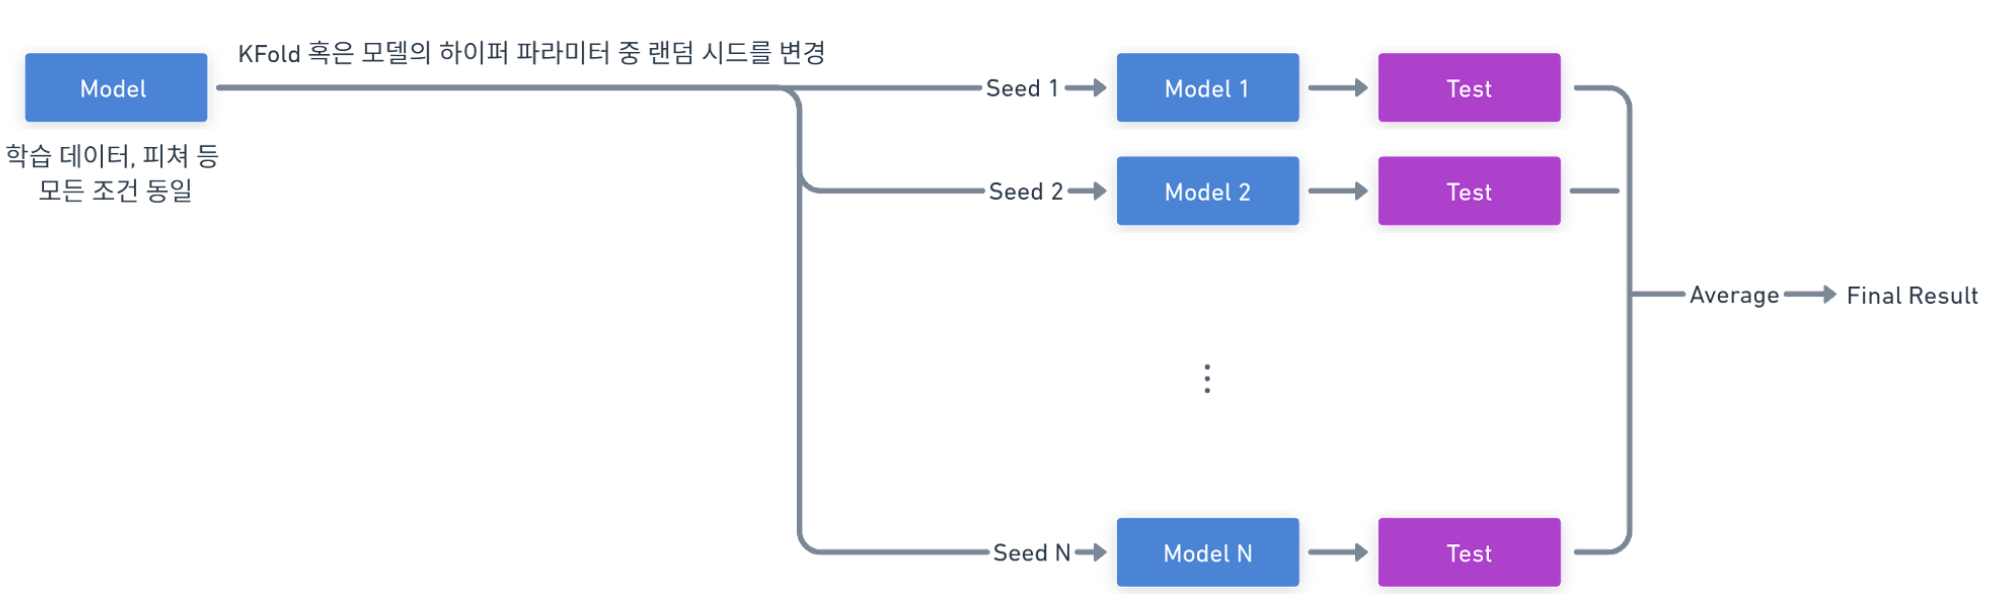

#### 👨‍💻 코드 : (2-3)

In [41]:
# random_state 목록
random_states = list(range(10))

# 각 random_state로 모델을 학습시키고 예측값을 저장
all_preds = []
RMSES = []

for rs in random_states:
    preds = train_and_predict(holdout_X_train, holdout_Y_train, holdout_X_valid, holdout_Y_valid, X_test, features, rs)
    RMSE = mean_squared_error(Y_test, preds)**0.5

    display(f"SEED {rs} Test rmse : {RMSE}")

    all_preds.append(preds)
    RMSES += [RMSE]

# 모든 예측값의 평균을 계산
ensemble_preds = np.mean(all_preds, axis=0)

# 앙상블의 RMSE를 측정
RMSE = mean_squared_error(Y_test, ensemble_preds)**0.5

display(RMSES)
display(f"Seed Ensemble Test RMSE : {RMSE}")

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 122836	valid_0's l2: 1.50887e+10	valid_1's rmse: 41075.2	valid_1's l2: 1.68717e+09
[20]	valid_0's rmse: 97033.5	valid_0's l2: 9.4155e+09	valid_1's rmse: 24195.7	valid_1's l2: 5.8543e+08
[30]	valid_0's rmse: 86630.6	valid_0's l2: 7.50487e+09	valid_1's rmse: 31671.8	valid_1's l2: 1.0031e+09
Early stopping, best iteration is:
[20]	valid_0's rmse: 97033.5	valid_0's l2: 9.4155e+09	valid_1's rmse: 24195.7	valid_1's l2: 5.8543e+08


'SEED 0 Test rmse : 87603.65177995748'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 121471	valid_0's l2: 1.47552e+10	valid_1's rmse: 42375.1	valid_1's l2: 1.79565e+09
[20]	valid_0's rmse: 96288.1	valid_0's l2: 9.2714e+09	valid_1's rmse: 18626.5	valid_1's l2: 3.46946e+08
Early stopping, best iteration is:
[19]	valid_0's rmse: 97675.7	valid_0's l2: 9.54055e+09	valid_1's rmse: 18352.7	valid_1's l2: 3.36821e+08


'SEED 1 Test rmse : 88164.00456544387'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 122158	valid_0's l2: 1.49226e+10	valid_1's rmse: 40139.2	valid_1's l2: 1.61115e+09
[20]	valid_0's rmse: 94536.2	valid_0's l2: 8.93709e+09	valid_1's rmse: 17007.3	valid_1's l2: 2.89248e+08
[30]	valid_0's rmse: 84064.4	valid_0's l2: 7.06682e+09	valid_1's rmse: 21426.5	valid_1's l2: 4.59093e+08
Early stopping, best iteration is:
[22]	valid_0's rmse: 91321.6	valid_0's l2: 8.33964e+09	valid_1's rmse: 16801.8	valid_1's l2: 2.823e+08


'SEED 2 Test rmse : 80858.3359799446'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 119308	valid_0's l2: 1.42343e+10	valid_1's rmse: 42794.9	valid_1's l2: 1.8314e+09
[20]	valid_0's rmse: 93655.9	valid_0's l2: 8.77143e+09	valid_1's rmse: 17036.6	valid_1's l2: 2.90245e+08
[30]	valid_0's rmse: 82938.5	valid_0's l2: 6.8788e+09	valid_1's rmse: 20190.9	valid_1's l2: 4.07674e+08
Early stopping, best iteration is:
[24]	valid_0's rmse: 89434.2	valid_0's l2: 7.99848e+09	valid_1's rmse: 16831.6	valid_1's l2: 2.83303e+08


'SEED 3 Test rmse : 77809.46576426465'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 124428	valid_0's l2: 1.54824e+10	valid_1's rmse: 41257	valid_1's l2: 1.70214e+09
[20]	valid_0's rmse: 95132	valid_0's l2: 9.05009e+09	valid_1's rmse: 18550.2	valid_1's l2: 3.44111e+08
[30]	valid_0's rmse: 84756.8	valid_0's l2: 7.18371e+09	valid_1's rmse: 29593.5	valid_1's l2: 8.75773e+08
Early stopping, best iteration is:
[20]	valid_0's rmse: 95132	valid_0's l2: 9.05009e+09	valid_1's rmse: 18550.2	valid_1's l2: 3.44111e+08


'SEED 4 Test rmse : 85543.84076042911'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 122826	valid_0's l2: 1.50863e+10	valid_1's rmse: 40344.7	valid_1's l2: 1.62769e+09
[20]	valid_0's rmse: 95101.2	valid_0's l2: 9.04425e+09	valid_1's rmse: 27692.8	valid_1's l2: 7.66891e+08
Early stopping, best iteration is:
[16]	valid_0's rmse: 101824	valid_0's l2: 1.03681e+10	valid_1's rmse: 27488.5	valid_1's l2: 7.55617e+08


'SEED 5 Test rmse : 94223.67851839651'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 122005	valid_0's l2: 1.48852e+10	valid_1's rmse: 42927.3	valid_1's l2: 1.84276e+09
[20]	valid_0's rmse: 95101.4	valid_0's l2: 9.04427e+09	valid_1's rmse: 21423.4	valid_1's l2: 4.58963e+08
[30]	valid_0's rmse: 86020.6	valid_0's l2: 7.39955e+09	valid_1's rmse: 28521.5	valid_1's l2: 8.13476e+08
Early stopping, best iteration is:
[20]	valid_0's rmse: 95101.4	valid_0's l2: 9.04427e+09	valid_1's rmse: 21423.4	valid_1's l2: 4.58963e+08


'SEED 6 Test rmse : 87775.21376209831'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 121177	valid_0's l2: 1.46838e+10	valid_1's rmse: 42500.8	valid_1's l2: 1.80632e+09
[20]	valid_0's rmse: 95131	valid_0's l2: 9.04991e+09	valid_1's rmse: 14818.2	valid_1's l2: 2.19579e+08
[30]	valid_0's rmse: 84547.4	valid_0's l2: 7.14826e+09	valid_1's rmse: 23539.6	valid_1's l2: 5.54111e+08
Early stopping, best iteration is:
[20]	valid_0's rmse: 95131	valid_0's l2: 9.04991e+09	valid_1's rmse: 14818.2	valid_1's l2: 2.19579e+08


'SEED 7 Test rmse : 84635.80767423747'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 122621	valid_0's l2: 1.5036e+10	valid_1's rmse: 40467.8	valid_1's l2: 1.63764e+09
[20]	valid_0's rmse: 95252	valid_0's l2: 9.07294e+09	valid_1's rmse: 25887.5	valid_1's l2: 6.70161e+08
[30]	valid_0's rmse: 84381.4	valid_0's l2: 7.12022e+09	valid_1's rmse: 33479.7	valid_1's l2: 1.12089e+09
Early stopping, best iteration is:
[23]	valid_0's rmse: 92124.2	valid_0's l2: 8.48686e+09	valid_1's rmse: 24987.7	valid_1's l2: 6.24385e+08


'SEED 8 Test rmse : 83587.78877361816'

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 121666	valid_0's l2: 1.48026e+10	valid_1's rmse: 45574.8	valid_1's l2: 2.07706e+09
[20]	valid_0's rmse: 94348.6	valid_0's l2: 8.90167e+09	valid_1's rmse: 18436.7	valid_1's l2: 3.39911e+08
[30]	valid_0's rmse: 83984.6	valid_0's l2: 7.05342e+09	valid_1's rmse: 27328.3	valid_1's l2: 7.46836e+08
Early stopping, best iteration is:
[21]	valid_0's rmse: 93571.4	valid_0's l2: 8.7556e+09	valid_1's rmse: 17650.7	valid_1's l2: 3.11548e+08


'SEED 9 Test rmse : 84655.7697620212'

[87603.65177995748,
 88164.00456544387,
 80858.3359799446,
 77809.46576426465,
 85543.84076042911,
 94223.67851839651,
 87775.21376209831,
 84635.80767423747,
 83587.78877361816,
 84655.7697620212]

'Seed Ensemble Test RMSE : 84947.66978073707'

- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s
  - Valid RMSE : 2966.63
  - Test RMSE : 3457.82

- Seed Ensemble 학습의 최종결과는 아래와 같습니다.
  - Training Time : 13.7s * 10
  - Seed RMSE : [3428, 3438, 3396, 3418, 3388, **3381**, 3474, 3523, 3429, 3509]

  - Test RMSE : 3262

# Reference

- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
- [Scikit-Learn](https://scikit-learn.org/stable/index.html)